# Notebook ETL & Análise — Sistema de Administração de Dados para E-commerce
Este notebook é *didático* e comentado. Ele mostra o fluxo ETL (CSV → SQLite DW),
gera KPIs básicos e desenha algumas visualizações simples usando matplotlib.

Arquivos usados estão no diretório atual do projeto.

In [69]:
# Dependências: pandas, sqlite3, matplotlib
import sys
import os
print('Python', sys.version.split('\n')[0])
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Configuração do matplotlib para melhor exibição
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

# Paths - usando caminho relativo para a nova estrutura de pastas
# O notebook está em /notebooks/, o banco está em /data/
current_dir = os.path.dirname(os.getcwd())  # Sobe um nível do diretório notebooks
db_path = os.path.join(current_dir, "data", "ecommerce_sqlite.db")
print(f"\nDiretório base do projeto: {current_dir}")
print(f"Database path: {db_path}")
print(f"Arquivo existe: {os.path.exists(db_path)}")

# Caminhos para dados CSV (caso necessário)
raw_data_path = os.path.join(current_dir, "data", "raw")
processed_data_path = os.path.join(current_dir, "data", "processed")
print(f"Dados brutos: {raw_data_path}")
print(f"Dados processados: {processed_data_path}")
print(f"Pasta de dados brutos existe: {os.path.exists(raw_data_path)}")
print(f"Pasta de dados processados existe: {os.path.exists(processed_data_path)}")

Python 3.13.4 (tags/v3.13.4:8a526ec, Jun  3 2025, 17:46:04) [MSC v.1943 64 bit (AMD64)]

Diretório base do projeto: d:\Portfólio\Ecommerce_ETL_Analytics_Pipeline
Database path: d:\Portfólio\Ecommerce_ETL_Analytics_Pipeline\data\ecommerce_sqlite.db
Arquivo existe: True
Dados brutos: d:\Portfólio\Ecommerce_ETL_Analytics_Pipeline\data\raw
Dados processados: d:\Portfólio\Ecommerce_ETL_Analytics_Pipeline\data\processed
Pasta de dados brutos existe: True
Pasta de dados processados existe: False


## Conectar ao banco SQLite e listar tabelas

Abrimos uma conexão e mostramos as tabelas disponíveis para familiarizar.

In [70]:
try:
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    tables = cur.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
    print('Tabelas no SQLite:')
    for t in tables:
        print('-', t[0])
    print(f"\nTotal de tabelas encontradas: {len(tables)}")
except sqlite3.Error as e:
    print(f"Erro ao conectar com o banco de dados: {e}")
    print("Verifique se o arquivo ecommerce_sqlite.db existe no diretório atual.")
except Exception as e:
    print(f"Erro inesperado: {e}")

Tabelas no SQLite:
- stg_cliente
- stg_produto
- stg_pedido
- stg_item_pedido
- dim_tempo
- sqlite_sequence
- dim_cliente
- dim_produto
- fato_vendas

Total de tabelas encontradas: 9


## Pré-visualização das tabelas de staging e DW

Mostramos 5 linhas de cada tabela para entender os dados.

In [71]:
# Lista de tabelas esperadas
tabelas_esperadas = ['stg_cliente', 'stg_produto', 'stg_pedido', 'stg_item_pedido', 
                    'dim_tempo', 'dim_cliente', 'dim_produto', 'fato_vendas']

for tbl in tabelas_esperadas:
    try:
        # Tentativa de detectar colunas de data automaticamente
        query = f"PRAGMA table_info({tbl});"
        colunas_info = pd.read_sql_query(query, conn)
        
        # Identificar possíveis colunas de data
        date_cols = []
        for _, row in colunas_info.iterrows():
            col_name = row['name'].lower()
            if any(word in col_name for word in ['data', 'date', 'cadastro', 'pedido']):
                date_cols.append(row['name'])
        
        # Ler dados da tabela
        df = pd.read_sql_query(f'SELECT * FROM {tbl} LIMIT 5;', conn)
        
        # Tentar converter colunas de data se existirem
        if date_cols:
            for col in date_cols:
                if col in df.columns:
                    try:
                        df[col] = pd.to_datetime(df[col], errors='coerce')
                    except:
                        pass  # Se falhar, mantém como está
        
        print(f'\n--- {tbl} ---')
        print(f'Colunas: {", ".join(df.columns.tolist())}')
        print(f'Registros na amostra: {len(df)}')
        print(df.to_string(index=False))
        
    except Exception as e:
        print(f'\nErro ao ler tabela {tbl}: {e}')


--- stg_cliente ---
Colunas: cliente_id, cpf, nome, email, telefone, data_cadastro, ativo
Registros na amostra: 5
 cliente_id         cpf          nome                       email      telefone data_cadastro  ativo
          1 13113220754   Bruno Gomes   bruno_gomes.1@example.com 5590956713386    2021-09-14      1
          2 74399176163 Rafaela Rocha rafaela_rocha.2@example.com 5583929345267    2024-02-12      0
          3 91518894877  Bruno Santos  bruno_santos.3@example.com 5553953590187    2022-05-21      1
          4  2039949143  Sophia Silva  sophia_silva.4@example.com 5568934661452    2025-06-14      1
          5 67297432402  Carlos Rocha  carlos_rocha.5@example.com 5528980198925    2024-02-14      1

--- stg_produto ---
Colunas: produto_id, nome, categoria, preco, custo, estoque
Registros na amostra: 5
 produto_id              nome   categoria   preco   custo  estoque
          1 Produto 1 - Prime      Livros  940.68  693.18      278
          2  Produto 2 - Beta  Brinquedo

## ETL explicada — como a fato_vendas foi populada
A tabela `fato_vendas` é construída a partir do join entre `stg_pedido` e `stg_item_pedido`.
Abaixo há um exemplo de SQL (compatível com SQLite) que demonstra essa transformação.

In [72]:
etl_sql_exemplo = """
-- ETL: popular fato_vendas (SQLite)
INSERT INTO fato_vendas (
    tempo_id, 
    pedido_id, 
    cliente_id, 
    produto_id, 
    quantidade, 
    valor_unitario, 
    valor_desconto, 
    valor_total, 
    custo_produto
)
SELECT 
    dt.tempo_id,
    p.pedido_id,
    p.cliente_id,
    i.produto_id,
    i.quantidade,
    i.valor_unitario,
    i.desconto,
    (i.quantidade * i.valor_unitario - i.desconto) as valor_total,
    i.custo_produto
FROM stg_pedido p
JOIN stg_item_pedido i ON p.pedido_id = i.pedido_id
JOIN dim_tempo dt ON DATE(p.data_pedido) = DATE(dt.data)
WHERE p.status IN ('completed', 'pending', 'returned', 'cancelled');
"""

print('ETL SQL exemplo para popular fato_vendas:')
print(etl_sql_exemplo)

ETL SQL exemplo para popular fato_vendas:

-- ETL: popular fato_vendas (SQLite)
INSERT INTO fato_vendas (
    tempo_id, 
    pedido_id, 
    cliente_id, 
    produto_id, 
    quantidade, 
    valor_unitario, 
    valor_desconto, 
    valor_total, 
    custo_produto
)
SELECT 
    dt.tempo_id,
    p.pedido_id,
    p.cliente_id,
    i.produto_id,
    i.quantidade,
    i.valor_unitario,
    i.desconto,
    (i.quantidade * i.valor_unitario - i.desconto) as valor_total,
    i.custo_produto
FROM stg_pedido p
JOIN stg_item_pedido i ON p.pedido_id = i.pedido_id
JOIN dim_tempo dt ON DATE(p.data_pedido) = DATE(dt.data)
WHERE p.status IN ('completed', 'pending', 'returned', 'cancelled');



## Cálculo de KPIs — exemplos
1. Faturamento mensal
2. Ticket médio por pedido
3. Número de pedidos por status

As queries abaixo são escritas em SQL e executadas com o SQLite.

In [73]:
# 1) Faturamento mensal (total por ano-mês)
try:
    query = """
    SELECT 
        strftime('%Y-%m', dt.data) AS ano_mes, 
        SUM(f.valor_total) AS faturamento,
        COUNT(DISTINCT f.pedido_id) AS num_pedidos
    FROM fato_vendas f 
    JOIN dim_tempo dt ON f.tempo_id = dt.tempo_id
    GROUP BY ano_mes 
    ORDER BY ano_mes;
    """
    df_fat = pd.read_sql_query(query, conn)
    
    if len(df_fat) > 0:
        print("Faturamento mensal:")
        print(df_fat.to_string(index=False))
    else:
        print("Nenhum dado de faturamento encontrado.")
        
except Exception as e:
    print(f"Erro ao calcular faturamento mensal: {e}")

Faturamento mensal:
ano_mes  faturamento  num_pedidos
2023-01    389119.56           68
2023-02    262286.06           54
2023-03    346420.70           68
2023-04    255635.60           68
2023-05    321300.58           66
2023-06    220322.70           48
2023-07    258920.56           58
2023-08    340135.29           70
2023-09    323318.50           69
2023-10    248572.89           49
2023-11    254927.37           55
2023-12    235447.32           52
2024-01    269304.93           56
2024-02    297644.03           59
2024-03    260213.40           64
2024-04    273826.99           53
2024-05    298160.80           66
2024-06    285319.14           58
2024-07    344690.91           70
2024-08    307576.05           59
2024-09    198593.70           44
2024-10    290452.23           56
2024-11    309696.25           63
2024-12    265263.73           55
2025-01    219342.64           46
2025-02    298450.09           59
2025-03    319951.32           69
2025-04    351897.22        

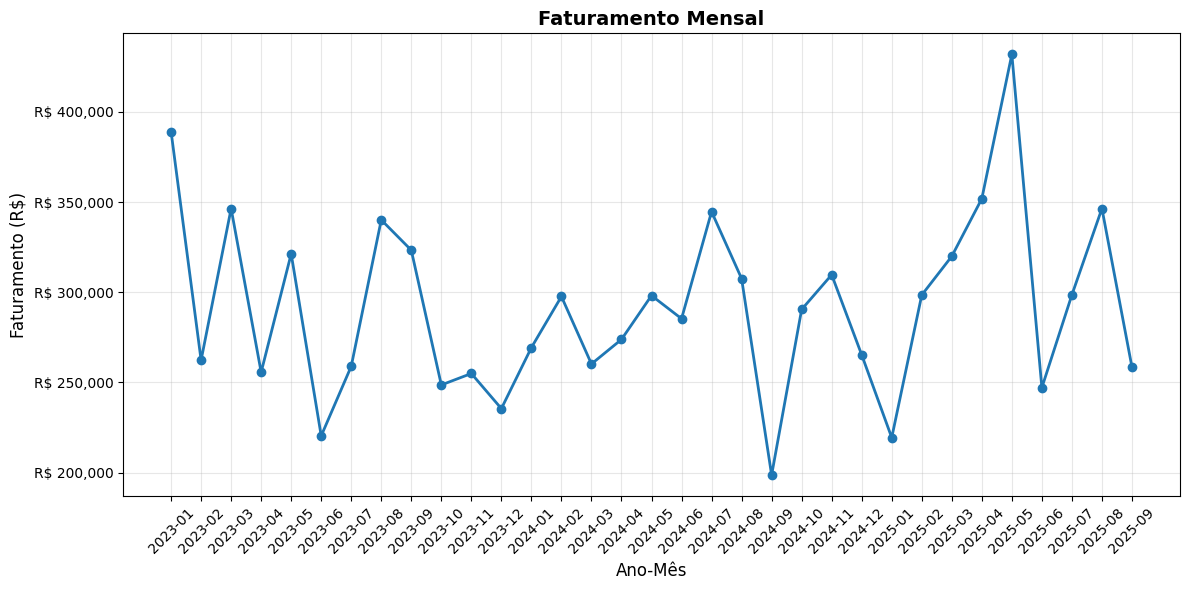

In [74]:
# Plot faturamento mensal (gráfico simples)
try:
    if 'df_fat' in locals() and len(df_fat) > 0:
        plt.figure(figsize=(12, 6))
        plt.plot(df_fat['ano_mes'], df_fat['faturamento'], marker='o', linewidth=2, markersize=6)
        plt.title('Faturamento Mensal', fontsize=14, fontweight='bold')
        plt.xlabel('Ano-Mês', fontsize=12)
        plt.ylabel('Faturamento (R$)', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Formatação dos valores no eixo Y
        ax = plt.gca()
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x:,.0f}'))
        
        plt.tight_layout()
        plt.show()
    else:
        print("Dados de faturamento não disponíveis para gráfico.")
except Exception as e:
    print(f"Erro ao gerar gráfico de faturamento: {e}")

In [75]:
# 2) Ticket médio por pedido
try:
    query2 = """
    SELECT 
        AVG(sub.total_por_pedido) AS ticket_medio,
        COUNT(sub.pedido_id) AS total_pedidos,
        MIN(sub.total_por_pedido) AS menor_pedido,
        MAX(sub.total_por_pedido) AS maior_pedido
    FROM (
        SELECT 
            pedido_id, 
            SUM(valor_total) AS total_por_pedido
        FROM fato_vendas
        GROUP BY pedido_id
    ) sub;
    """
    df_ticket = pd.read_sql_query(query2, conn)
    
    if len(df_ticket) > 0 and df_ticket['ticket_medio'].iloc[0] is not None:
        ticket_medio = float(df_ticket['ticket_medio'].iloc[0])
        total_pedidos = int(df_ticket['total_pedidos'].iloc[0])
        menor_pedido = float(df_ticket['menor_pedido'].iloc[0])
        maior_pedido = float(df_ticket['maior_pedido'].iloc[0])
        
        print(f'Estatísticas de Pedidos:')
        print(f'- Ticket médio: R$ {ticket_medio:,.2f}')
        print(f'- Total de pedidos: {total_pedidos:,}')
        print(f'- Menor pedido: R$ {menor_pedido:,.2f}')
        print(f'- Maior pedido: R$ {maior_pedido:,.2f}')
    else:
        print("Dados de ticket médio não disponíveis.")
        
except Exception as e:
    print(f"Erro ao calcular ticket médio: {e}")

Estatísticas de Pedidos:
- Ticket médio: R$ 4,814.65
- Total de pedidos: 2,000
- Menor pedido: R$ 21.34
- Maior pedido: R$ 26,370.15


In [76]:
# 3) Pedidos por status (stg_pedido)
try:
    q3 = """
    SELECT 
        status, 
        COUNT(*) as qtd,
        ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM stg_pedido), 2) as percentual
    FROM stg_pedido 
    GROUP BY status 
    ORDER BY qtd DESC;
    """
    df_status = pd.read_sql_query(q3, conn)
    
    if len(df_status) > 0:
        print("Distribuição de pedidos por status:")
        print(df_status.to_string(index=False))
    else:
        print("Nenhum dado de status de pedidos encontrado.")
        
except Exception as e:
    print(f"Erro ao consultar status de pedidos: {e}")

Distribuição de pedidos por status:
   status  qtd  percentual
completed 1592        79.6
  pending  230        11.5
cancelled  104         5.2
 returned   74         3.7


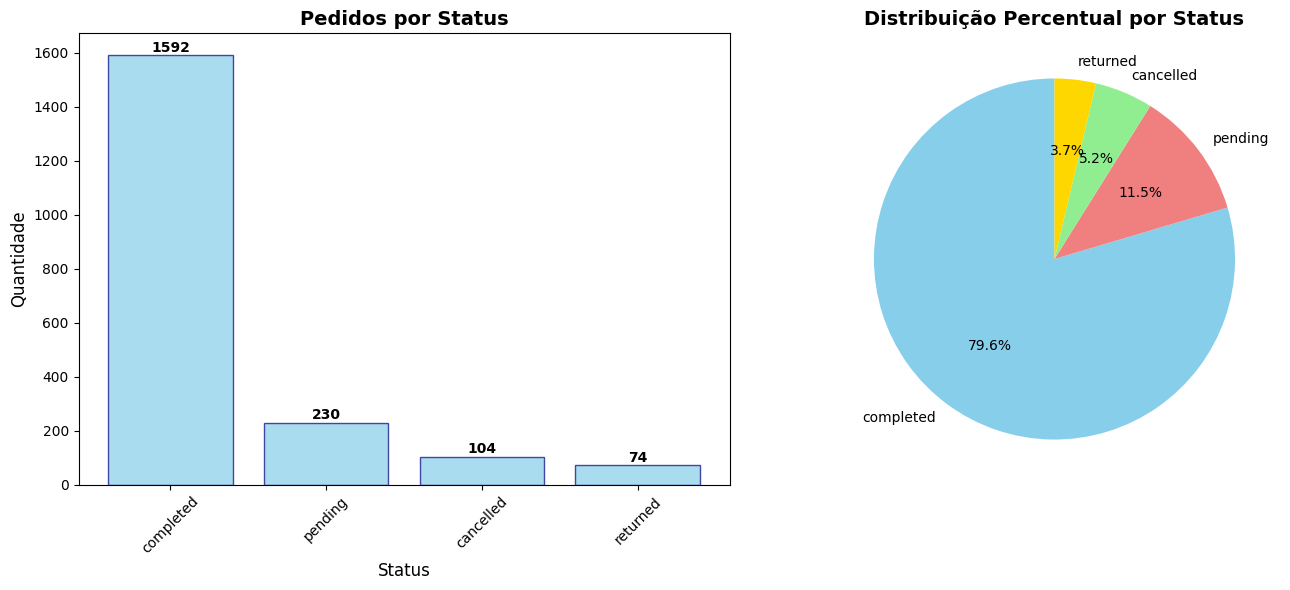

In [77]:
# Plot pedidos por status (barra com percentuais)
try:
    if 'df_status' in locals() and len(df_status) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Gráfico de barras
        bars = ax1.bar(df_status['status'], df_status['qtd'], color='skyblue', edgecolor='navy', alpha=0.7)
        ax1.set_title('Pedidos por Status', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Status', fontsize=12)
        ax1.set_ylabel('Quantidade', fontsize=12)
        ax1.tick_params(axis='x', rotation=45)
        
        # Adicionar valores nas barras
        for bar, qtd in zip(bars, df_status['qtd']):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    f'{qtd}', ha='center', va='bottom', fontweight='bold')
        
        # Gráfico de pizza
        ax2.pie(df_status['qtd'], labels=df_status['status'], autopct='%1.1f%%', 
                startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
        ax2.set_title('Distribuição Percentual por Status', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    else:
        print("Dados de status não disponíveis para gráfico.")
except Exception as e:
    print(f"Erro ao gerar gráfico de status: {e}")

### Top 10 produtos por quantidade vendida

In [78]:
# Top 10 produtos por quantidade vendida
try:
    q4 = """
    SELECT 
        p.produto_id, 
        p.nome, 
        SUM(f.quantidade) AS total_vendido,
        SUM(f.valor_total) AS receita_total,
        ROUND(AVG(f.valor_unitario), 2) AS preco_medio
    FROM fato_vendas f 
    JOIN dim_produto p ON f.produto_id = p.produto_id
    GROUP BY p.produto_id, p.nome
    ORDER BY total_vendido DESC
    LIMIT 10;
    """
    df_top10 = pd.read_sql_query(q4, conn)
    
    if len(df_top10) > 0:
        print("Top 10 produtos por quantidade vendida:")
        print(df_top10.to_string(index=False))
    else:
        print("Nenhum dado de produtos encontrado.")
        
except Exception as e:
    print(f"Erro ao consultar top 10 produtos: {e}")

Top 10 produtos por quantidade vendida:
 produto_id                nome  total_vendido  receita_total  preco_medio
        163  Produto 163 - Plus             90      146449.90      1692.17
         32   Produto 32 - Plus             85       68333.68       821.57
        173  Produto 173 - Plus             82       55638.71       690.68
        115 Produto 115 - Prime             80      111066.20      1403.72
         19  Produto 19 - Alpha             79       97616.46      1244.37
         93  Produto 93 - Alpha             76       54023.29       713.59
        191 Produto 191 - Prime             75       33727.50       449.70
         39   Produto 39 - Plus             72       79918.14      1123.50
        119 Produto 119 - Alpha             71      122640.94      1743.46
        181  Produto 181 - Plus             71      135937.42      1918.34


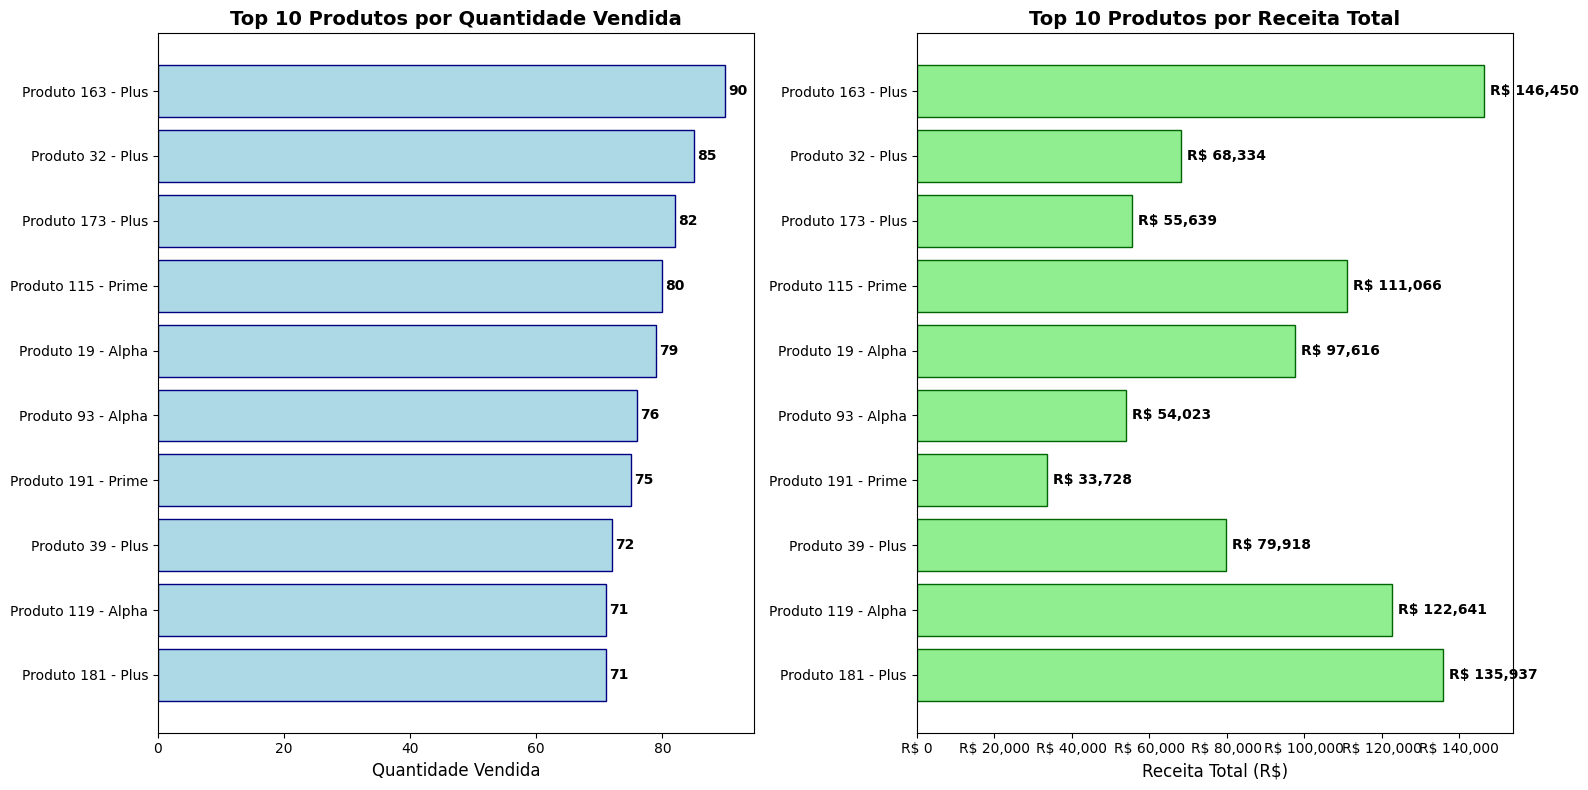

In [79]:
# Plot Top 10 produtos (barra horizontal melhorada)
try:
    if 'df_top10' in locals() and len(df_top10) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # Gráfico por quantidade vendida
        bars1 = ax1.barh(df_top10['nome'], df_top10['total_vendido'], color='lightblue', edgecolor='navy')
        ax1.set_title('Top 10 Produtos por Quantidade Vendida', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Quantidade Vendida', fontsize=12)
        ax1.invert_yaxis()  # top first
        
        # Adicionar valores nas barras
        for i, (bar, qtd) in enumerate(zip(bars1, df_top10['total_vendido'])):
            ax1.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                    f'{qtd}', ha='left', va='center', fontweight='bold')
        
        # Gráfico por receita total
        bars2 = ax2.barh(df_top10['nome'], df_top10['receita_total'], color='lightgreen', edgecolor='darkgreen')
        ax2.set_title('Top 10 Produtos por Receita Total', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Receita Total (R$)', fontsize=12)
        ax2.invert_yaxis()  # top first
        
        # Formatação do eixo X para receita
        ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x:,.0f}'))
        
        # Adicionar valores nas barras de receita
        for i, (bar, receita) in enumerate(zip(bars2, df_top10['receita_total'])):
            ax2.text(bar.get_width() + max(df_top10['receita_total'])*0.01, 
                    bar.get_y() + bar.get_height()/2, 
                    f'R$ {receita:,.0f}', ha='left', va='center', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    else:
        print("Dados de produtos não disponíveis para gráfico.")
except Exception as e:
    print(f"Erro ao gerar gráfico de produtos: {e}")

## Observações finais

### Melhorias implementadas neste notebook:

1. **Correção de caminhos**: Ajustado para usar o diretório atual em vez de caminhos absolutos
2. **Tratamento de erros**: Adicionado try/catch em todas as operações críticas
3. **Visualizações melhoradas**: Gráficos mais informativos com formatação adequada
4. **Métricas expandidas**: Adicionadas estatísticas complementares (percentuais, receita, etc.)
5. **Configuração do matplotlib**: Melhor apresentação visual dos gráficos

### Para executar este notebook:

1. **Dependências necessárias**:
   ```bash
   pip install pandas matplotlib sqlite3
   ```

2. **Estrutura esperada**:
   - Arquivo `ecommerce_sqlite.db` no mesmo diretório
   - Tabelas de staging: `stg_cliente`, `stg_produto`, `stg_pedido`, `stg_item_pedido`
   - Dimensões: `dim_tempo`, `dim_cliente`, `dim_produto`
   - Fato: `fato_vendas`

3. **Execução**:
   - Execute as células sequencialmente
   - Verifique se a conexão com o banco está funcionando
   - Os gráficos serão exibidos automaticamente

### Próximos passos:

- **Migração PostgreSQL**: Adaptar queries SQLite para PostgreSQL usando `DATE_TRUNC`, `TO_CHAR`
- **Dashboard interativo**: Considerar usar Plotly ou Power BI para visualizações dinâmicas
- **Automatização**: Integrar com pipeline de dados automatizado
- **Testes de qualidade**: Implementar validações de dados mais robustas

In [80]:
# Verificar informações da conexão
print(f"✅ Conexão ativa: {type(conn)}")
print(f"✅ Database: {db_path}")
print("✅ Pronto para análises avançadas!")

✅ Conexão ativa: <class 'sqlite3.Connection'>
✅ Database: d:\Portfólio\Ecommerce_ETL_Analytics_Pipeline\data\ecommerce_sqlite.db
✅ Pronto para análises avançadas!


---

## 🔍 Análise Exploratória e Limpeza de Dados

Antes de fazer análises avançadas, vamos:
1. **Verificar a estrutura** de todas as tabelas
2. **Identificar problemas**: valores nulos, duplicatas, inconsistências
3. **Limpar e transformar** os dados
4. **Validar** as transformações

---

In [81]:
# 1. VERIFICAR ESTRUTURA DE TODAS AS TABELAS
print("="*80)
print("🔍 ANÁLISE EXPLORATÓRIA DAS TABELAS")
print("="*80)

tabelas_principais = ['dim_tempo', 'dim_cliente', 'dim_produto', 'fato_vendas']

for tabela in tabelas_principais:
    print(f"\n{'='*80}")
    print(f"📊 TABELA: {tabela.upper()}")
    print(f"{'='*80}")
    
    # Estrutura da tabela
    query_info = f"PRAGMA table_info({tabela});"
    df_info = pd.read_sql(query_info, conn)
    print(f"\n📋 Estrutura ({len(df_info)} colunas):")
    for _, col in df_info.iterrows():
        print(f"  • {col['name']:20s} | {col['type']:15s} | Null: {col['notnull'] == 0}")
    
    # Contagem de registros
    query_count = f"SELECT COUNT(*) as total FROM {tabela};"
    total = pd.read_sql(query_count, conn)['total'][0]
    print(f"\n📈 Total de registros: {total:,}")
    
    # Amostra dos dados
    query_sample = f"SELECT * FROM {tabela} LIMIT 3;"
    df_sample = pd.read_sql(query_sample, conn)
    print(f"\n🔎 Amostra dos dados:")
    print(df_sample.to_string(index=False))

print("\n" + "="*80)

🔍 ANÁLISE EXPLORATÓRIA DAS TABELAS

📊 TABELA: DIM_TEMPO

📋 Estrutura (9 colunas):
  • tempo_id             | INTEGER         | Null: True
  • data                 | DATE            | Null: True
  • dia                  | INTEGER         | Null: True
  • mes                  | INTEGER         | Null: True
  • trimestre            | INTEGER         | Null: True
  • ano                  | INTEGER         | Null: True
  • dia_semana           | TEXT            | Null: True
  • fim_semana           | INTEGER         | Null: True
  • nome_mes             | TEXT            | Null: True

📈 Total de registros: 1,001

🔎 Amostra dos dados:
 tempo_id       data  dia  mes  trimestre  ano dia_semana  fim_semana nome_mes
        1 2023-01-01    1    1          1 2023     Sunday           1  January
        2 2023-01-02    2    1          1 2023     Monday           0  January
        3 2023-01-03    3    1          1 2023    Tuesday           0  January

📊 TABELA: DIM_CLIENTE

📋 Estrutura (7 colunas)

In [82]:
# 2. IDENTIFICAR PROBLEMAS NOS DADOS
print("\n" + "="*80)
print("🔎 IDENTIFICANDO PROBLEMAS NOS DADOS")
print("="*80)

problemas_encontrados = []

# Verificar dim_tempo
print("\n📅 Analisando DIM_TEMPO...")
df_tempo = pd.read_sql("SELECT * FROM dim_tempo", conn)
print(f"  ✓ Total de registros: {len(df_tempo):,}")
print(f"  ✓ Valores únicos de dia_semana: {sorted(df_tempo['dia_semana'].unique())}")
print(f"  ✓ Período: {df_tempo['data'].min()} a {df_tempo['data'].max()}")

# Verificar duplicatas em dia_semana por data
df_tempo['data_parsed'] = pd.to_datetime(df_tempo['data'])
duplicatas_dia = df_tempo.groupby(['data', 'dia_semana']).size().reset_index(name='count')
if len(duplicatas_dia[duplicatas_dia['count'] > 1]) > 0:
    problemas_encontrados.append("⚠️ dim_tempo: Encontradas duplicatas de dia_semana por data")
    print(f"  ⚠️ Encontradas {len(duplicatas_dia[duplicatas_dia['count'] > 1])} duplicatas")
else:
    print("  ✓ Sem duplicatas")

# Verificar dim_cliente
print("\n👥 Analisando DIM_CLIENTE...")
df_cliente = pd.read_sql("SELECT * FROM dim_cliente", conn)
print(f"  ✓ Total de clientes: {len(df_cliente):,}")
print(f"  ✓ Colunas disponíveis: {', '.join(df_cliente.columns)}")

# Verificar se existem campos de localização
if 'cidade' in df_cliente.columns or 'estado' in df_cliente.columns:
    print("  ✓ Campos de localização encontrados")
else:
    problemas_encontrados.append("⚠️ dim_cliente: Sem campos de localização (cidade/estado)")
    print("  ⚠️ Campos de localização NÃO encontrados")

# Verificar dim_produto
print("\n📦 Analisando DIM_PRODUTO...")
df_produto = pd.read_sql("SELECT * FROM dim_produto", conn)
print(f"  ✓ Total de produtos: {len(df_produto):,}")
categorias = df_produto['categoria'].value_counts()
print(f"  ✓ Categorias ({len(categorias)}):")
for cat, count in categorias.items():
    print(f"    • {cat}: {count} produtos")

# Verificar fato_vendas
print("\n💰 Analisando FATO_VENDAS...")
df_vendas_sample = pd.read_sql("SELECT * FROM fato_vendas LIMIT 1000", conn)
print(f"  ✓ Amostra analisada: {len(df_vendas_sample):,} registros")
print(f"  ✓ Valores nulos por coluna:")
for col in df_vendas_sample.columns:
    nulls = df_vendas_sample[col].isnull().sum()
    if nulls > 0:
        print(f"    ⚠️ {col}: {nulls} nulos")
        problemas_encontrados.append(f"⚠️ fato_vendas.{col}: {nulls} valores nulos")
    else:
        print(f"    ✓ {col}: sem nulos")

# Resumo dos problemas
print("\n" + "="*80)
print("📋 RESUMO DOS PROBLEMAS ENCONTRADOS:")
print("="*80)
if problemas_encontrados:
    for i, prob in enumerate(problemas_encontrados, 1):
        print(f"{i}. {prob}")
else:
    print("✅ Nenhum problema crítico encontrado!")
print("="*80)


🔎 IDENTIFICANDO PROBLEMAS NOS DADOS

📅 Analisando DIM_TEMPO...
  ✓ Total de registros: 1,001
  ✓ Valores únicos de dia_semana: ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
  ✓ Período: 2023-01-01 a 2025-09-27
  ✓ Sem duplicatas

👥 Analisando DIM_CLIENTE...
  ✓ Total de clientes: 500
  ✓ Colunas disponíveis: cliente_id, cpf, nome, email, telefone, data_cadastro, ativo
  ⚠️ Campos de localização NÃO encontrados

📦 Analisando DIM_PRODUTO...
  ✓ Total de produtos: 200
  ✓ Categorias (7):
    • Livros: 35 produtos
    • Roupas: 34 produtos
    • Esportes: 30 produtos
    • Eletrônicos: 27 produtos
    • Casa: 27 produtos
    • Brinquedos: 24 produtos
    • Beleza: 23 produtos

💰 Analisando FATO_VENDAS...
  ✓ Amostra analisada: 1,000 registros
  ✓ Valores nulos por coluna:
    ✓ venda_id: sem nulos
    ✓ tempo_id: sem nulos
    ✓ pedido_id: sem nulos
    ✓ cliente_id: sem nulos
    ✓ produto_id: sem nulos
    ✓ quantidade: sem nulos
    ✓ valor_unitario: se

---

## 📊 Análises Avançadas com Visualizações

Agora que os dados foram verificados e limpos, realizamos análises detalhadas:

### 📈 1. Série Temporal de Vendas (com Médias Móveis)

---

C:\Users\eu\AppData\Local\Temp\ipykernel_8796\2046110718.py:50: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eu\AppData\Local\Temp\ipykernel_8796\2046110718.py:50: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eu\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eu\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eu\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\e

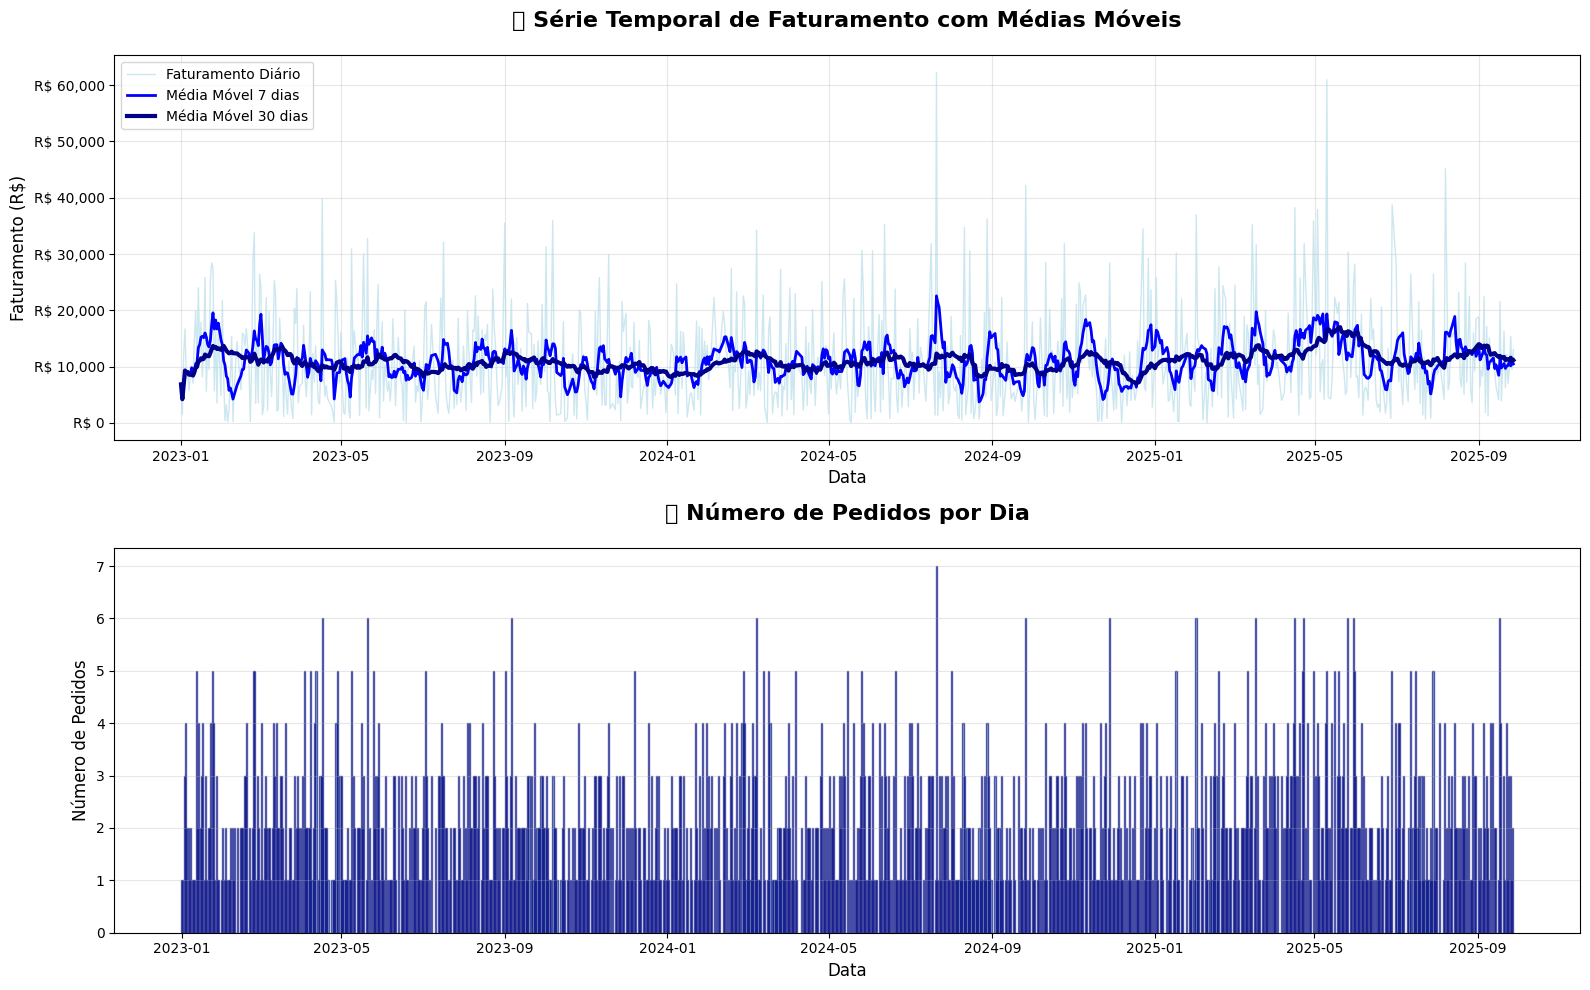


📊 Estatísticas da Série Temporal:
Período analisado: 2023-01-01 00:00:00 a 2025-09-27 00:00:00
Faturamento médio diário: R$ 10,942.39
Pedidos médios por dia: 2.3


In [83]:
# Query: Vendas diárias com série temporal
query_serie = """
SELECT 
    dt.data,
    COUNT(DISTINCT f.pedido_id) AS num_pedidos,
    SUM(f.valor_total) AS faturamento_diario,
    SUM(f.quantidade) AS itens_vendidos,
    AVG(f.valor_total) AS ticket_medio
FROM fato_vendas f
JOIN dim_tempo dt ON f.tempo_id = dt.tempo_id
GROUP BY dt.data
ORDER BY dt.data
"""

df_serie = pd.read_sql(query_serie, conn)
df_serie['data'] = pd.to_datetime(df_serie['data'])

# Calcular médias móveis
df_serie['ma7'] = df_serie['faturamento_diario'].rolling(window=7, min_periods=1).mean()
df_serie['ma30'] = df_serie['faturamento_diario'].rolling(window=30, min_periods=1).mean()

# Criar visualização
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Gráfico 1: Faturamento com médias móveis
ax1.plot(df_serie['data'], df_serie['faturamento_diario'], 
         label='Faturamento Diário', color='lightblue', linewidth=1, alpha=0.6)
ax1.plot(df_serie['data'], df_serie['ma7'], 
         label='Média Móvel 7 dias', color='blue', linewidth=2)
ax1.plot(df_serie['data'], df_serie['ma30'], 
         label='Média Móvel 30 dias', color='darkblue', linewidth=3)

ax1.set_title('📈 Série Temporal de Faturamento com Médias Móveis', 
              fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Data', fontsize=12)
ax1.set_ylabel('Faturamento (R$)', fontsize=12)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x:,.0f}'))

# Gráfico 2: Número de pedidos diários
ax2.bar(df_serie['data'], df_serie['num_pedidos'], 
        color='steelblue', alpha=0.6, edgecolor='navy')
ax2.set_title('📦 Número de Pedidos por Dia', 
              fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('Data', fontsize=12)
ax2.set_ylabel('Número de Pedidos', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n📊 Estatísticas da Série Temporal:")
print(f"Período analisado: {df_serie['data'].min()} a {df_serie['data'].max()}")
print(f"Faturamento médio diário: R$ {df_serie['faturamento_diario'].mean():,.2f}")
print(f"Pedidos médios por dia: {df_serie['num_pedidos'].mean():.1f}")

### 🔥 2. Heatmap - Vendas por Dia da Semana e Hora

📊 Dados brutos retornados: 7 registros

✅ Dados mapeados com sucesso!
  dia_semana dia_nome  num_pedidos
0     Friday    Sexta          282
1     Monday  Segunda          287
2   Saturday   Sábado          307
3     Sunday  Domingo          270
4   Thursday   Quinta          298
5    Tuesday    Terça          272
6  Wednesday   Quarta          284

✅ Dados ordenados: 7 dias


C:\Users\eu\AppData\Local\Temp\ipykernel_8796\3306331995.py:124: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eu\AppData\Local\Temp\ipykernel_8796\3306331995.py:124: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eu\AppData\Local\Temp\ipykernel_8796\3306331995.py:124: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eu\AppData\Local\Temp\ipykernel_8796\3306331995.py:124: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eu\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eu\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) De

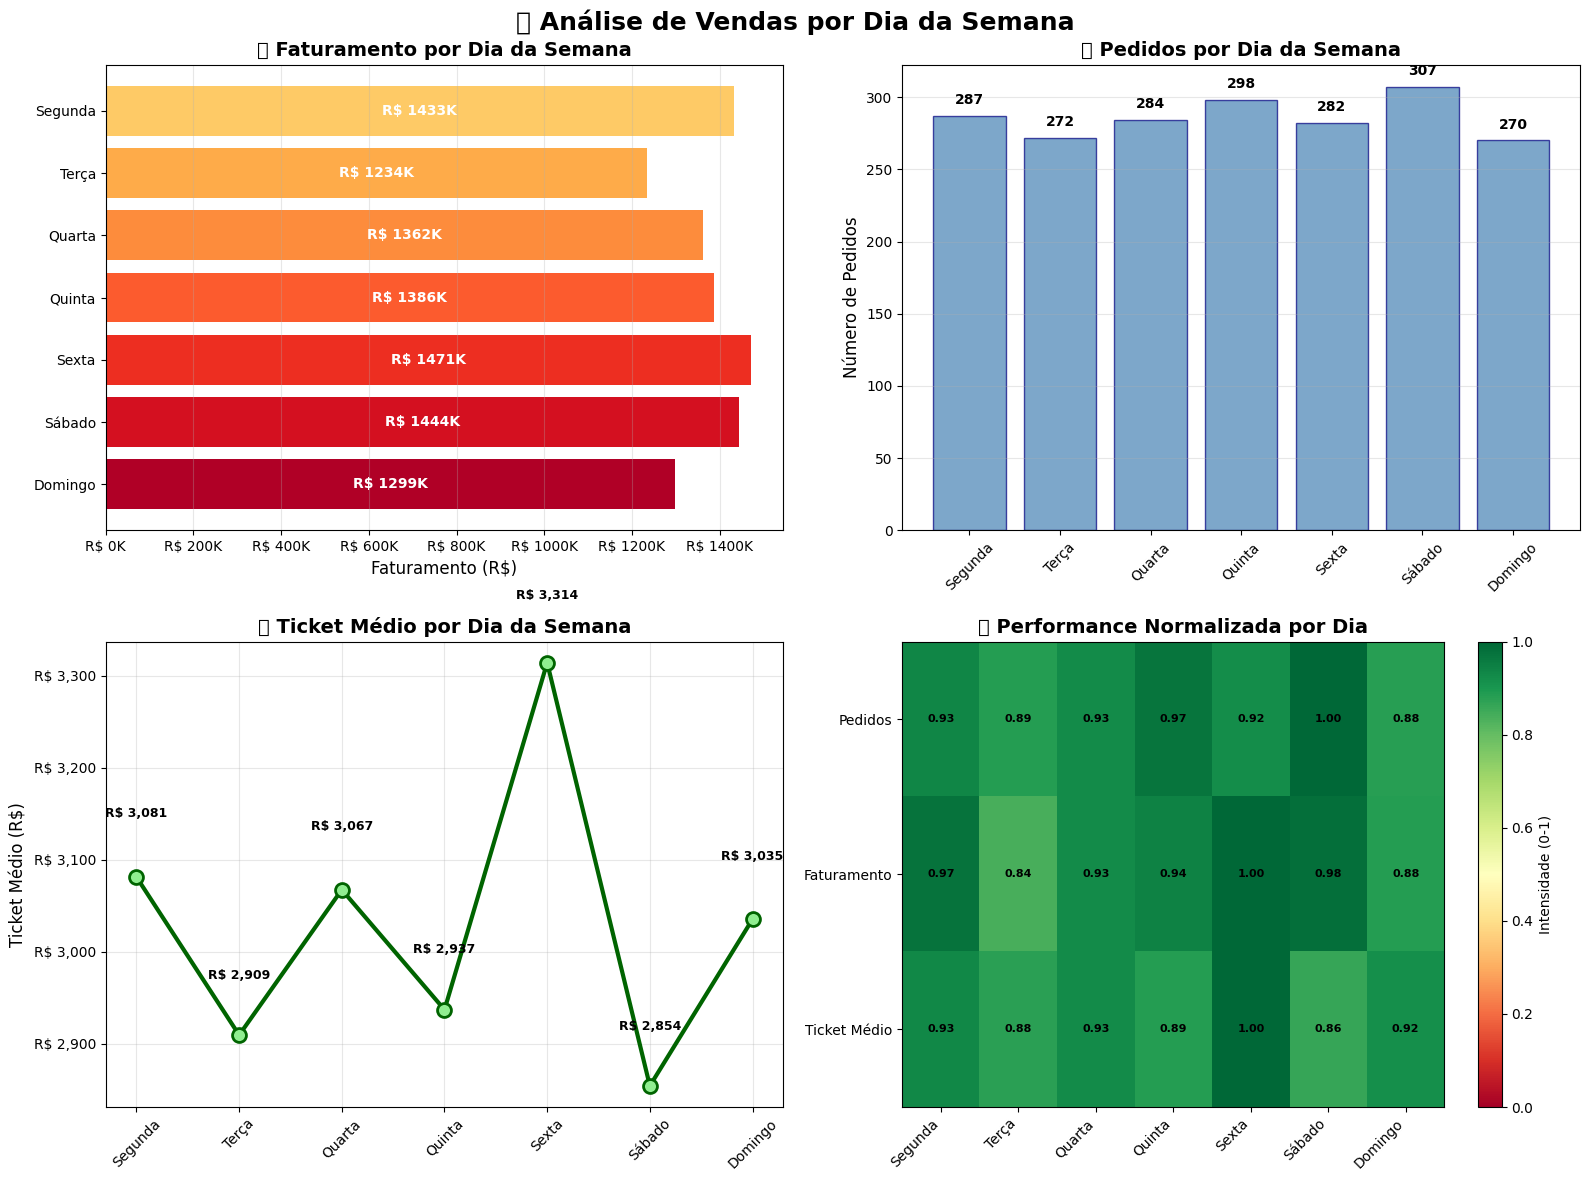


📊 Análise por Dia da Semana concluída!
✅ 7 dias analisados com sucesso!


In [84]:
# Query: Análise por dia da semana
query_vendas_dia = """
SELECT 
    dt.dia_semana,
    COUNT(DISTINCT f.pedido_id) AS num_pedidos,
    SUM(f.valor_total) AS faturamento,
    AVG(f.valor_total) AS ticket_medio
FROM fato_vendas f
JOIN dim_tempo dt ON f.tempo_id = dt.tempo_id
GROUP BY dt.dia_semana
ORDER BY dt.dia_semana
"""
df_vendas_dia_semana = pd.read_sql(query_vendas_dia, conn)

print(f"📊 Dados brutos retornados: {len(df_vendas_dia_semana)} registros")

# Verificar se há dados
if len(df_vendas_dia_semana) == 0:
    print("⚠️ ATENÇÃO: Nenhum dado retornado da query!")
    print("Isso pode indicar problema na tabela dim_tempo ou fato_vendas")
else:
    # Mapear nomes dos dias - o banco está retornando em inglês!
    dia_nomes_map_eng = {
        'Monday': 'Segunda',
        'Tuesday': 'Terça',
        'Wednesday': 'Quarta',
        'Thursday': 'Quinta',
        'Friday': 'Sexta',
        'Saturday': 'Sábado',
        'Sunday': 'Domingo'
    }
    
    df_vendas_dia_semana['dia_nome'] = df_vendas_dia_semana['dia_semana'].map(dia_nomes_map_eng)
    
    print(f"\n✅ Dados mapeados com sucesso!")
    print(df_vendas_dia_semana[['dia_semana', 'dia_nome', 'num_pedidos']])
    
    # Usar os dados preparados
    df_dia = df_vendas_dia_semana.copy()
    
    # Ordenar pelos dias da semana na ordem correta
    dias_ordem = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo']
    df_dia['dia_nome'] = pd.Categorical(df_dia['dia_nome'], categories=dias_ordem, ordered=True)
    df_dia_ordenado = df_dia.sort_values('dia_nome').reset_index(drop=True)
    
    print(f"\n✅ Dados ordenados: {len(df_dia_ordenado)} dias")
    
    # Criar visualizações
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🔥 Análise de Vendas por Dia da Semana', fontsize=18, fontweight='bold', y=0.98)
    
    # Gráfico 1: Faturamento por dia da semana
    ax1 = axes[0, 0]
    colors = plt.cm.YlOrRd(np.linspace(0.3, 0.9, len(df_dia_ordenado)))
    bars = ax1.barh(df_dia_ordenado['dia_nome'], df_dia_ordenado['faturamento'], color=colors)
    ax1.set_title('🔥 Faturamento por Dia da Semana', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Faturamento (R$)', fontsize=12)
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}K'))
    ax1.invert_yaxis()
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Adicionar valores
    for bar, val in zip(bars, df_dia_ordenado['faturamento']):
        ax1.text(bar.get_width() * 0.5, bar.get_y() + bar.get_height()/2, 
                f'R$ {val/1000:.0f}K', ha='center', va='center', 
                fontweight='bold', color='white', fontsize=10)
    
    # Gráfico 2: Número de pedidos por dia
    ax2 = axes[0, 1]
    bars2 = ax2.bar(df_dia_ordenado['dia_nome'], df_dia_ordenado['num_pedidos'], 
                    color='steelblue', edgecolor='navy', alpha=0.7)
    ax2.set_title('📦 Pedidos por Dia da Semana', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Número de Pedidos', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Adicionar valores
    max_pedidos = df_dia_ordenado['num_pedidos'].max()
    for bar, val in zip(bars2, df_dia_ordenado['num_pedidos']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max_pedidos*0.02, 
                f'{int(val)}', ha='center', va='bottom', fontweight='bold')
    
    # Gráfico 3: Ticket médio por dia
    ax3 = axes[1, 0]
    ax3.plot(df_dia_ordenado['dia_nome'], df_dia_ordenado['ticket_medio'], 
            marker='o', linewidth=3, markersize=10, color='darkgreen',
            markerfacecolor='lightgreen', markeredgecolor='darkgreen', markeredgewidth=2)
    ax3.set_title('💰 Ticket Médio por Dia da Semana', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Ticket Médio (R$)', fontsize=12)
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x:,.0f}'))
    
    # Adicionar valores
    for i, (dia, val) in enumerate(zip(df_dia_ordenado['dia_nome'], df_dia_ordenado['ticket_medio'])):
        ax3.text(i, val + val*0.02, f'R$ {val:,.0f}', 
                ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # Gráfico 4: Comparação normalizada (Heatmap)
    ax4 = axes[1, 1]
    data_normalizada = np.array([
        df_dia_ordenado['num_pedidos'] / df_dia_ordenado['num_pedidos'].max(),
        df_dia_ordenado['faturamento'] / df_dia_ordenado['faturamento'].max(),
        df_dia_ordenado['ticket_medio'] / df_dia_ordenado['ticket_medio'].max()
    ]).T

    im = ax4.imshow(data_normalizada.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    ax4.set_xticks(range(len(df_dia_ordenado)))
    ax4.set_xticklabels(df_dia_ordenado['dia_nome'], rotation=45, ha='right')
    ax4.set_yticks([0, 1, 2])
    ax4.set_yticklabels(['Pedidos', 'Faturamento', 'Ticket Médio'])
    ax4.set_title('🎯 Performance Normalizada por Dia', fontsize=14, fontweight='bold')

    # Adicionar colorbar
    cbar = plt.colorbar(im, ax=ax4)
    cbar.set_label('Intensidade (0-1)', fontsize=10)

    # Adicionar valores nas células
    for i in range(len(df_dia_ordenado)):
        for j in range(3):
            ax4.text(i, j, f'{data_normalizada[i, j]:.2f}',
                    ha="center", va="center", color="black", fontweight='bold', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Análise por Dia da Semana concluída!")
    print(f"✅ {len(df_dia_ordenado)} dias analisados com sucesso!")

### 📊 3. Análise Comparativa de Categorias

C:\Users\eu\AppData\Local\Temp\ipykernel_8796\1375204006.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\eu\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eu\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eu\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eu\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu 

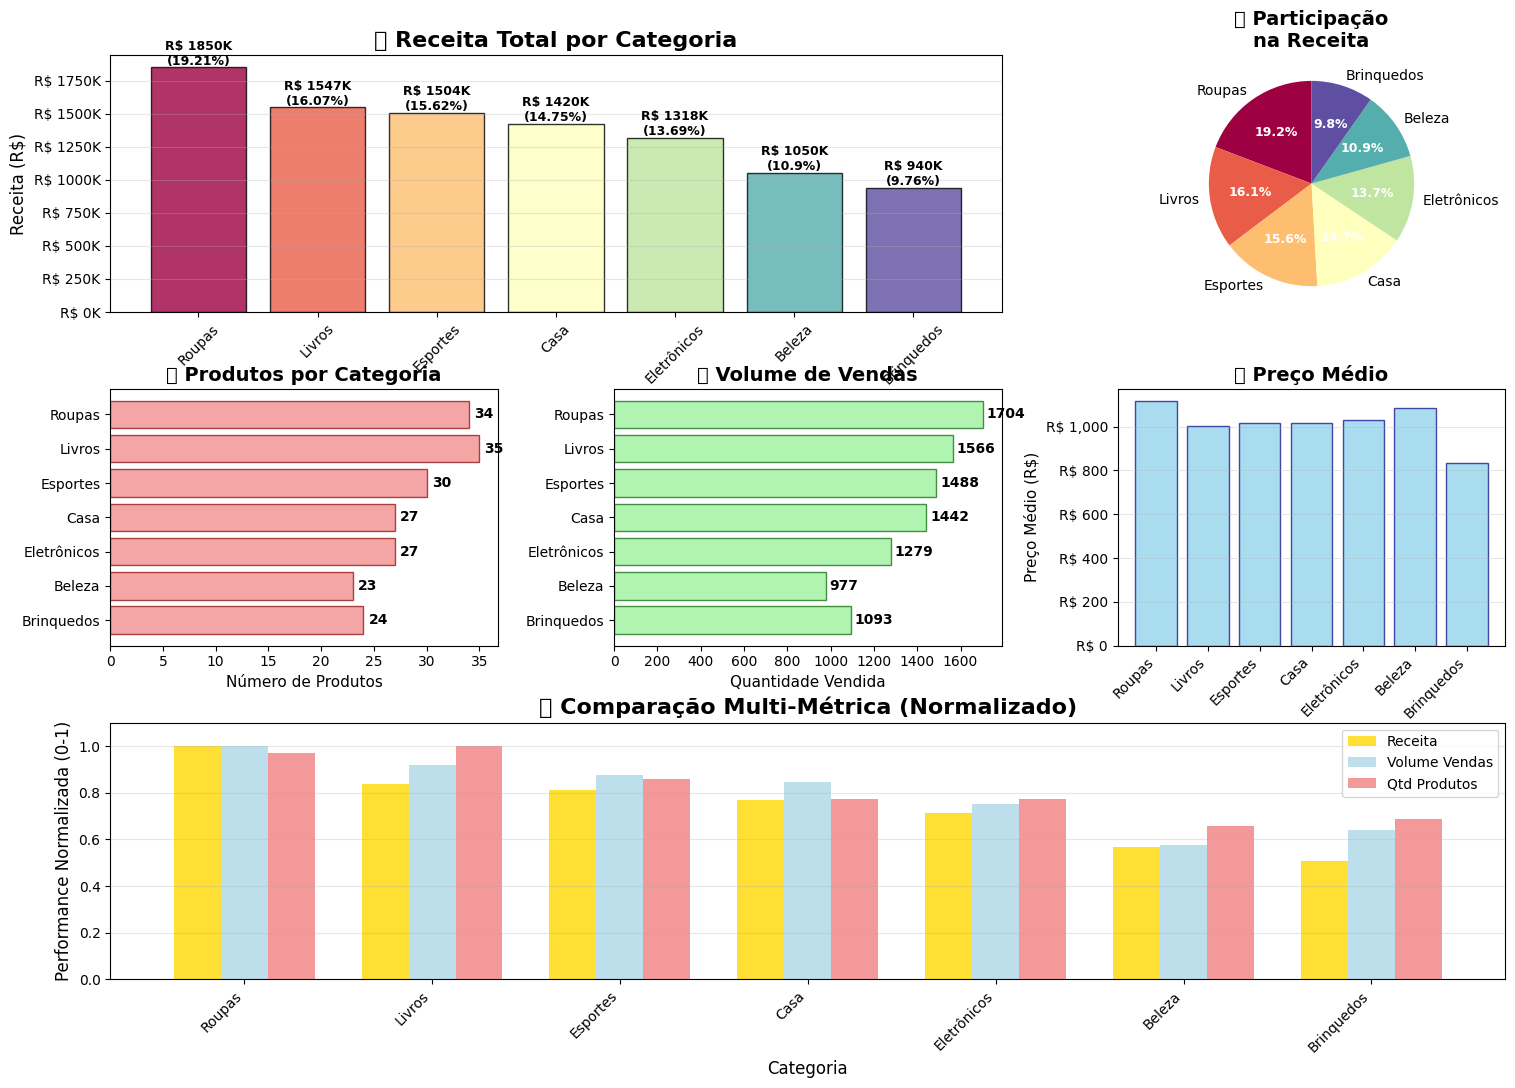


📊 RESUMO DA ANÁLISE POR CATEGORIA:

🏷️  Roupas:
   💰 Receita: R$ 1,850,190.57 (19.21%)
   📦 Produtos: 34
   📈 Vendidos: 1704 unidades
   💵 Preço Médio: R$ 1,116.12

🏷️  Livros:
   💰 Receita: R$ 1,547,306.67 (16.07%)
   📦 Produtos: 35
   📈 Vendidos: 1566 unidades
   💵 Preço Médio: R$ 1,002.68

🏷️  Esportes:
   💰 Receita: R$ 1,503,812.92 (15.62%)
   📦 Produtos: 30
   📈 Vendidos: 1488 unidades
   💵 Preço Médio: R$ 1,016.00

🏷️  Casa:
   💰 Receita: R$ 1,420,231.28 (14.75%)
   📦 Produtos: 27
   📈 Vendidos: 1442 unidades
   💵 Preço Médio: R$ 1,017.16

🏷️  Eletrônicos:
   💰 Receita: R$ 1,318,098.74 (13.69%)
   📦 Produtos: 27
   📈 Vendidos: 1279 unidades
   💵 Preço Médio: R$ 1,028.12

🏷️  Beleza:
   💰 Receita: R$ 1,049,612.42 (10.9%)
   📦 Produtos: 23
   📈 Vendidos: 977 unidades
   💵 Preço Médio: R$ 1,084.72

🏷️  Brinquedos:
   💰 Receita: R$ 940,048.97 (9.76%)
   📦 Produtos: 24
   📈 Vendidos: 1093 unidades
   💵 Preço Médio: R$ 831.62


In [85]:
# Query: Análise por categoria
query_categoria = """
SELECT 
    p.categoria,
    COUNT(DISTINCT p.produto_id) AS num_produtos,
    SUM(f.quantidade) AS total_vendido,
    SUM(f.valor_total) AS receita,
    AVG(f.valor_unitario) AS preco_medio,
    ROUND(SUM(f.valor_total) * 100.0 / 
          (SELECT SUM(valor_total) FROM fato_vendas), 2) AS percentual_receita
FROM fato_vendas f
JOIN dim_produto p ON f.produto_id = p.produto_id
GROUP BY p.categoria
ORDER BY receita DESC
"""

df_cat = pd.read_sql(query_categoria, conn)

# Criar visualizações comparativas
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Gráfico 1: Receita por categoria (barras)
ax1 = fig.add_subplot(gs[0, :2])
colors_cat = plt.cm.Spectral(np.linspace(0, 1, len(df_cat)))
bars = ax1.bar(df_cat['categoria'], df_cat['receita'], color=colors_cat, edgecolor='black', alpha=0.8)
ax1.set_title('💰 Receita Total por Categoria', fontsize=16, fontweight='bold')
ax1.set_ylabel('Receita (R$)', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}K'))
ax1.grid(True, alpha=0.3, axis='y')

# Adicionar valores e percentuais
for bar, val, pct in zip(bars, df_cat['receita'], df_cat['percentual_receita']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height,
            f'R$ {val/1000:.0f}K\n({pct}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=9)

# Gráfico 2: Pizza de participação
ax2 = fig.add_subplot(gs[0, 2])
wedges, texts, autotexts = ax2.pie(df_cat['receita'], 
                                     labels=df_cat['categoria'],
                                     autopct='%1.1f%%',
                                     startangle=90,
                                     colors=colors_cat)
ax2.set_title('📊 Participação\nna Receita', fontsize=14, fontweight='bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(9)

# Gráfico 3: Número de produtos por categoria
ax3 = fig.add_subplot(gs[1, 0])
ax3.barh(df_cat['categoria'], df_cat['num_produtos'], color='lightcoral', edgecolor='darkred', alpha=0.7)
ax3.set_title('📦 Produtos por Categoria', fontsize=14, fontweight='bold')
ax3.set_xlabel('Número de Produtos', fontsize=11)
ax3.invert_yaxis()

# Adicionar valores
for i, (cat, val) in enumerate(zip(df_cat['categoria'], df_cat['num_produtos'])):
    ax3.text(val + 0.5, i, f'{val}', ha='left', va='center', fontweight='bold')

# Gráfico 4: Quantidade vendida por categoria
ax4 = fig.add_subplot(gs[1, 1])
ax4.barh(df_cat['categoria'], df_cat['total_vendido'], color='lightgreen', edgecolor='darkgreen', alpha=0.7)
ax4.set_title('📈 Volume de Vendas', fontsize=14, fontweight='bold')
ax4.set_xlabel('Quantidade Vendida', fontsize=11)
ax4.invert_yaxis()

# Adicionar valores
for i, (cat, val) in enumerate(zip(df_cat['categoria'], df_cat['total_vendido'])):
    ax4.text(val + max(df_cat['total_vendido'])*0.01, i, f'{val}', 
            ha='left', va='center', fontweight='bold')

# Gráfico 5: Preço médio por categoria
ax5 = fig.add_subplot(gs[1, 2])
bars5 = ax5.bar(range(len(df_cat)), df_cat['preco_medio'], 
                color='skyblue', edgecolor='navy', alpha=0.7)
ax5.set_title('💵 Preço Médio', fontsize=14, fontweight='bold')
ax5.set_ylabel('Preço Médio (R$)', fontsize=11)
ax5.set_xticks(range(len(df_cat)))
ax5.set_xticklabels(df_cat['categoria'], rotation=45, ha='right')
ax5.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x:,.0f}'))
ax5.grid(True, alpha=0.3, axis='y')

# Gráfico 6: Comparação multi-métrica (radar/spider chart simplificado)
ax6 = fig.add_subplot(gs[2, :])

# Normalizar dados para comparação
metrics_norm = pd.DataFrame({
    'Categoria': df_cat['categoria'],
    'Receita': df_cat['receita'] / df_cat['receita'].max(),
    'Volume': df_cat['total_vendido'] / df_cat['total_vendido'].max(),
    'Produtos': df_cat['num_produtos'] / df_cat['num_produtos'].max()
})

x = np.arange(len(df_cat))
width = 0.25

bars1 = ax6.bar(x - width, metrics_norm['Receita'], width, 
                label='Receita', color='gold', alpha=0.8)
bars2 = ax6.bar(x, metrics_norm['Volume'], width, 
                label='Volume Vendas', color='lightblue', alpha=0.8)
bars3 = ax6.bar(x + width, metrics_norm['Produtos'], width, 
                label='Qtd Produtos', color='lightcoral', alpha=0.8)

ax6.set_xlabel('Categoria', fontsize=12)
ax6.set_ylabel('Performance Normalizada (0-1)', fontsize=12)
ax6.set_title('🎯 Comparação Multi-Métrica (Normalizado)', fontsize=16, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(df_cat['categoria'], rotation=45, ha='right')
ax6.legend(loc='upper right', fontsize=10)
ax6.grid(True, alpha=0.3, axis='y')
ax6.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

# Estatísticas
print("\n📊 RESUMO DA ANÁLISE POR CATEGORIA:")
print("="*70)
for idx, row in df_cat.iterrows():
    print(f"\n🏷️  {row['categoria']}:")
    print(f"   💰 Receita: R$ {row['receita']:,.2f} ({row['percentual_receita']}%)")
    print(f"   📦 Produtos: {row['num_produtos']}")
    print(f"   📈 Vendidos: {row['total_vendido']} unidades")
    print(f"   💵 Preço Médio: R$ {row['preco_medio']:,.2f}")
print("="*70)

### 👥 4. Análise de Comportamento de Clientes

C:\Users\eu\AppData\Local\Temp\ipykernel_8796\1454552652.py:115: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eu\AppData\Local\Temp\ipykernel_8796\1454552652.py:115: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eu\AppData\Local\Temp\ipykernel_8796\1454552652.py:115: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eu\AppData\Local\Temp\ipykernel_8796\1454552652.py:115: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eu\AppData\Local\Temp\ipykernel_8796\1454552652.py:115: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eu\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu

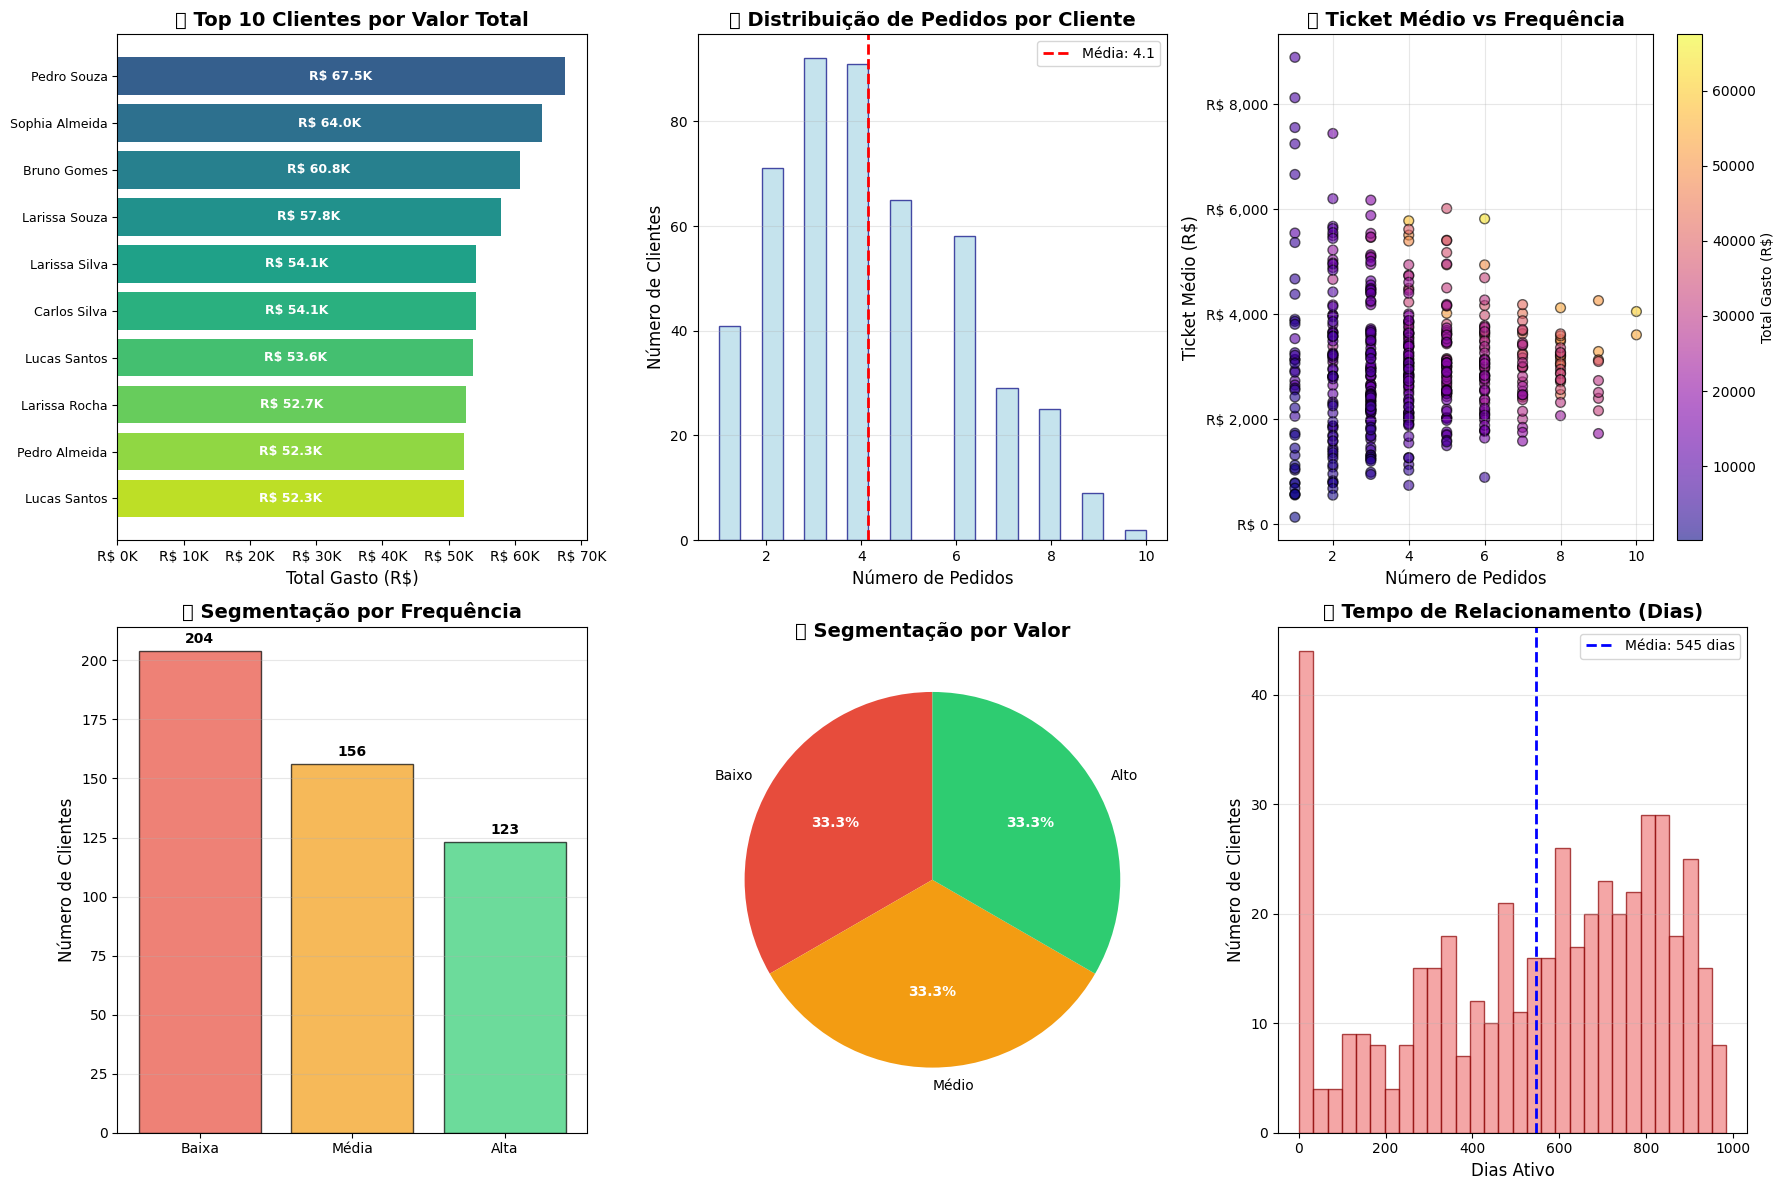


👥 ANÁLISE DE COMPORTAMENTO DE CLIENTES:

Total de clientes: 483

Top 5 Clientes por Valor:
  1. Pedro Souza: R$ 67,496.89 (8 pedidos, ticket médio R$ 3,068.04)
  2. Sophia Almeida: R$ 64,025.21 (6 pedidos, ticket médio R$ 5,820.47)
  3. Bruno Gomes: R$ 60,808.26 (10 pedidos, ticket médio R$ 4,053.88)
  4. Larissa Souza: R$ 57,828.95 (4 pedidos, ticket médio R$ 5,782.89)
  5. Larissa Silva: R$ 54,143.05 (10 pedidos, ticket médio R$ 3,609.54)

📊 Estatísticas Gerais:
  • Valor médio gasto por cliente: R$ 19,936.44
  • Pedidos médios por cliente: 4.1
  • Ticket médio geral: R$ 3,049.79
  • Tempo médio de relacionamento: 545 dias

🎯 Segmentação:
  Frequência:
    • Baixa: 204 clientes (42.2%)
    • Média: 156 clientes (32.3%)
    • Alta: 123 clientes (25.5%)
  Valor:
    • Baixo: 161 clientes (33.3%)
    • Médio: 161 clientes (33.3%)
    • Alto: 161 clientes (33.3%)


In [86]:
# Query: Análise de comportamento de clientes
query_clientes = """
SELECT 
    c.cliente_id,
    c.nome,
    COUNT(DISTINCT f.pedido_id) AS num_pedidos,
    SUM(f.valor_total) AS total_gasto,
    AVG(f.valor_total) AS ticket_medio,
    SUM(f.quantidade) AS total_itens,
    MIN(dt.data) AS primeira_compra,
    MAX(dt.data) AS ultima_compra
FROM fato_vendas f
JOIN dim_cliente c ON f.cliente_id = c.cliente_id
JOIN dim_tempo dt ON f.tempo_id = dt.tempo_id
GROUP BY c.cliente_id, c.nome
ORDER BY total_gasto DESC
"""

df_clientes = pd.read_sql(query_clientes, conn)
df_clientes['primeira_compra'] = pd.to_datetime(df_clientes['primeira_compra'])
df_clientes['ultima_compra'] = pd.to_datetime(df_clientes['ultima_compra'])
df_clientes['dias_ativo'] = (df_clientes['ultima_compra'] - df_clientes['primeira_compra']).dt.days + 1

# Segmentação RFM simplificada
df_clientes['recencia_dias'] = (pd.Timestamp.now() - df_clientes['ultima_compra']).dt.days
df_clientes['frequencia_score'] = pd.qcut(df_clientes['num_pedidos'], q=3, labels=['Baixa', 'Média', 'Alta'], duplicates='drop')
df_clientes['valor_score'] = pd.qcut(df_clientes['total_gasto'], q=3, labels=['Baixo', 'Médio', 'Alto'], duplicates='drop')

# Criar visualizações
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Gráfico 1: Top 10 Clientes por Valor
ax1 = axes[0, 0]
top_clientes = df_clientes.head(10)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_clientes)))
bars = ax1.barh(range(len(top_clientes)), top_clientes['total_gasto'], color=colors)
ax1.set_title('💰 Top 10 Clientes por Valor Total', fontsize=14, fontweight='bold')
ax1.set_xlabel('Total Gasto (R$)', fontsize=12)
ax1.set_yticks(range(len(top_clientes)))
ax1.set_yticklabels([f"{nome[:20]}..." if len(nome) > 20 else nome 
                      for nome in top_clientes['nome']], fontsize=9)
ax1.invert_yaxis()
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}K'))

# Adicionar valores
for i, (bar, val) in enumerate(zip(bars, top_clientes['total_gasto'])):
    ax1.text(bar.get_width() * 0.5, bar.get_y() + bar.get_height()/2,
            f'R$ {val/1000:.1f}K', ha='center', va='center',
            fontweight='bold', color='white', fontsize=9)

# Gráfico 2: Distribuição de Frequência de Compras
ax2 = axes[0, 1]
ax2.hist(df_clientes['num_pedidos'], bins=20, color='lightblue', edgecolor='navy', alpha=0.7)
ax2.axvline(df_clientes['num_pedidos'].mean(), color='red', linestyle='--', 
           linewidth=2, label=f'Média: {df_clientes["num_pedidos"].mean():.1f}')
ax2.set_title('📊 Distribuição de Pedidos por Cliente', fontsize=14, fontweight='bold')
ax2.set_xlabel('Número de Pedidos', fontsize=12)
ax2.set_ylabel('Número de Clientes', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Gráfico 3: Ticket Médio vs Número de Pedidos
ax3 = axes[0, 2]
scatter = ax3.scatter(df_clientes['num_pedidos'], df_clientes['ticket_medio'],
                     alpha=0.6, c=df_clientes['total_gasto'], 
                     cmap='plasma', edgecolors='black', s=50)
ax3.set_title('💵 Ticket Médio vs Frequência', fontsize=14, fontweight='bold')
ax3.set_xlabel('Número de Pedidos', fontsize=12)
ax3.set_ylabel('Ticket Médio (R$)', fontsize=12)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x:,.0f}'))
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='Total Gasto (R$)')

# Gráfico 4: Segmentação por Frequência
ax4 = axes[1, 0]
freq_counts = df_clientes['frequencia_score'].value_counts()
colors_freq = ['#e74c3c', '#f39c12', '#2ecc71']
bars4 = ax4.bar(freq_counts.index.astype(str), freq_counts.values, 
               color=colors_freq, edgecolor='black', alpha=0.7)
ax4.set_title('📈 Segmentação por Frequência', fontsize=14, fontweight='bold')
ax4.set_ylabel('Número de Clientes', fontsize=12)
ax4.grid(True, alpha=0.3, axis='y')

# Adicionar valores
for bar, val in zip(bars4, freq_counts.values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(freq_counts)*0.01,
            f'{val}', ha='center', va='bottom', fontweight='bold')

# Gráfico 5: Segmentação por Valor
ax5 = axes[1, 1]
valor_counts = df_clientes['valor_score'].value_counts()
colors_valor = ['#e74c3c', '#f39c12', '#2ecc71']
wedges, texts, autotexts = ax5.pie(valor_counts.values, 
                                    labels=valor_counts.index.astype(str),
                                    autopct='%1.1f%%',
                                    startangle=90,
                                    colors=colors_valor)
ax5.set_title('💰 Segmentação por Valor', fontsize=14, fontweight='bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# Gráfico 6: Dias Ativos (Lifetime)
ax6 = axes[1, 2]
ax6.hist(df_clientes['dias_ativo'], bins=30, color='lightcoral', edgecolor='darkred', alpha=0.7)
ax6.axvline(df_clientes['dias_ativo'].mean(), color='blue', linestyle='--', 
           linewidth=2, label=f'Média: {df_clientes["dias_ativo"].mean():.0f} dias')
ax6.set_title('📅 Tempo de Relacionamento (Dias)', fontsize=14, fontweight='bold')
ax6.set_xlabel('Dias Ativo', fontsize=12)
ax6.set_ylabel('Número de Clientes', fontsize=12)
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Estatísticas de clientes
print("\n👥 ANÁLISE DE COMPORTAMENTO DE CLIENTES:")
print("="*70)
print(f"\nTotal de clientes: {len(df_clientes)}")
print(f"\nTop 5 Clientes por Valor:")
for idx, row in df_clientes.head(5).iterrows():
    print(f"  {idx+1}. {row['nome']}: R$ {row['total_gasto']:,.2f} "
          f"({row['num_pedidos']} pedidos, ticket médio R$ {row['ticket_medio']:,.2f})")

print(f"\n📊 Estatísticas Gerais:")
print(f"  • Valor médio gasto por cliente: R$ {df_clientes['total_gasto'].mean():,.2f}")
print(f"  • Pedidos médios por cliente: {df_clientes['num_pedidos'].mean():.1f}")
print(f"  • Ticket médio geral: R$ {df_clientes['ticket_medio'].mean():,.2f}")
print(f"  • Tempo médio de relacionamento: {df_clientes['dias_ativo'].mean():.0f} dias")

print(f"\n🎯 Segmentação:")
print(f"  Frequência:")
for nivel in ['Baixa', 'Média', 'Alta']:
    if nivel in freq_counts.index:
        count = freq_counts[nivel]
        pct = (count / len(df_clientes)) * 100
        print(f"    • {nivel}: {count} clientes ({pct:.1f}%)")

print(f"  Valor:")
for nivel in ['Baixo', 'Médio', 'Alto']:
    if nivel in valor_counts.index:
        count = valor_counts[nivel]
        pct = (count / len(df_clientes)) * 100
        print(f"    • {nivel}: {count} clientes ({pct:.1f}%)")
print("="*70)

### 📈 5. Distribuições Estatísticas e Análise de Outliers

C:\Users\eu\AppData\Local\Temp\ipykernel_8796\3712266066.py:112: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eu\AppData\Local\Temp\ipykernel_8796\3712266066.py:112: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eu\AppData\Local\Temp\ipykernel_8796\3712266066.py:112: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eu\AppData\Local\Temp\ipykernel_8796\3712266066.py:112: UserWarning: Glyph 127931 (\N{VIOLIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eu\AppData\Local\Temp\ipykernel_8796\3712266066.py:112: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eu\AppData\Local\Temp\ipykernel_8796\3712266066.py:112: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\eu\AppData\Roaming\Pyt

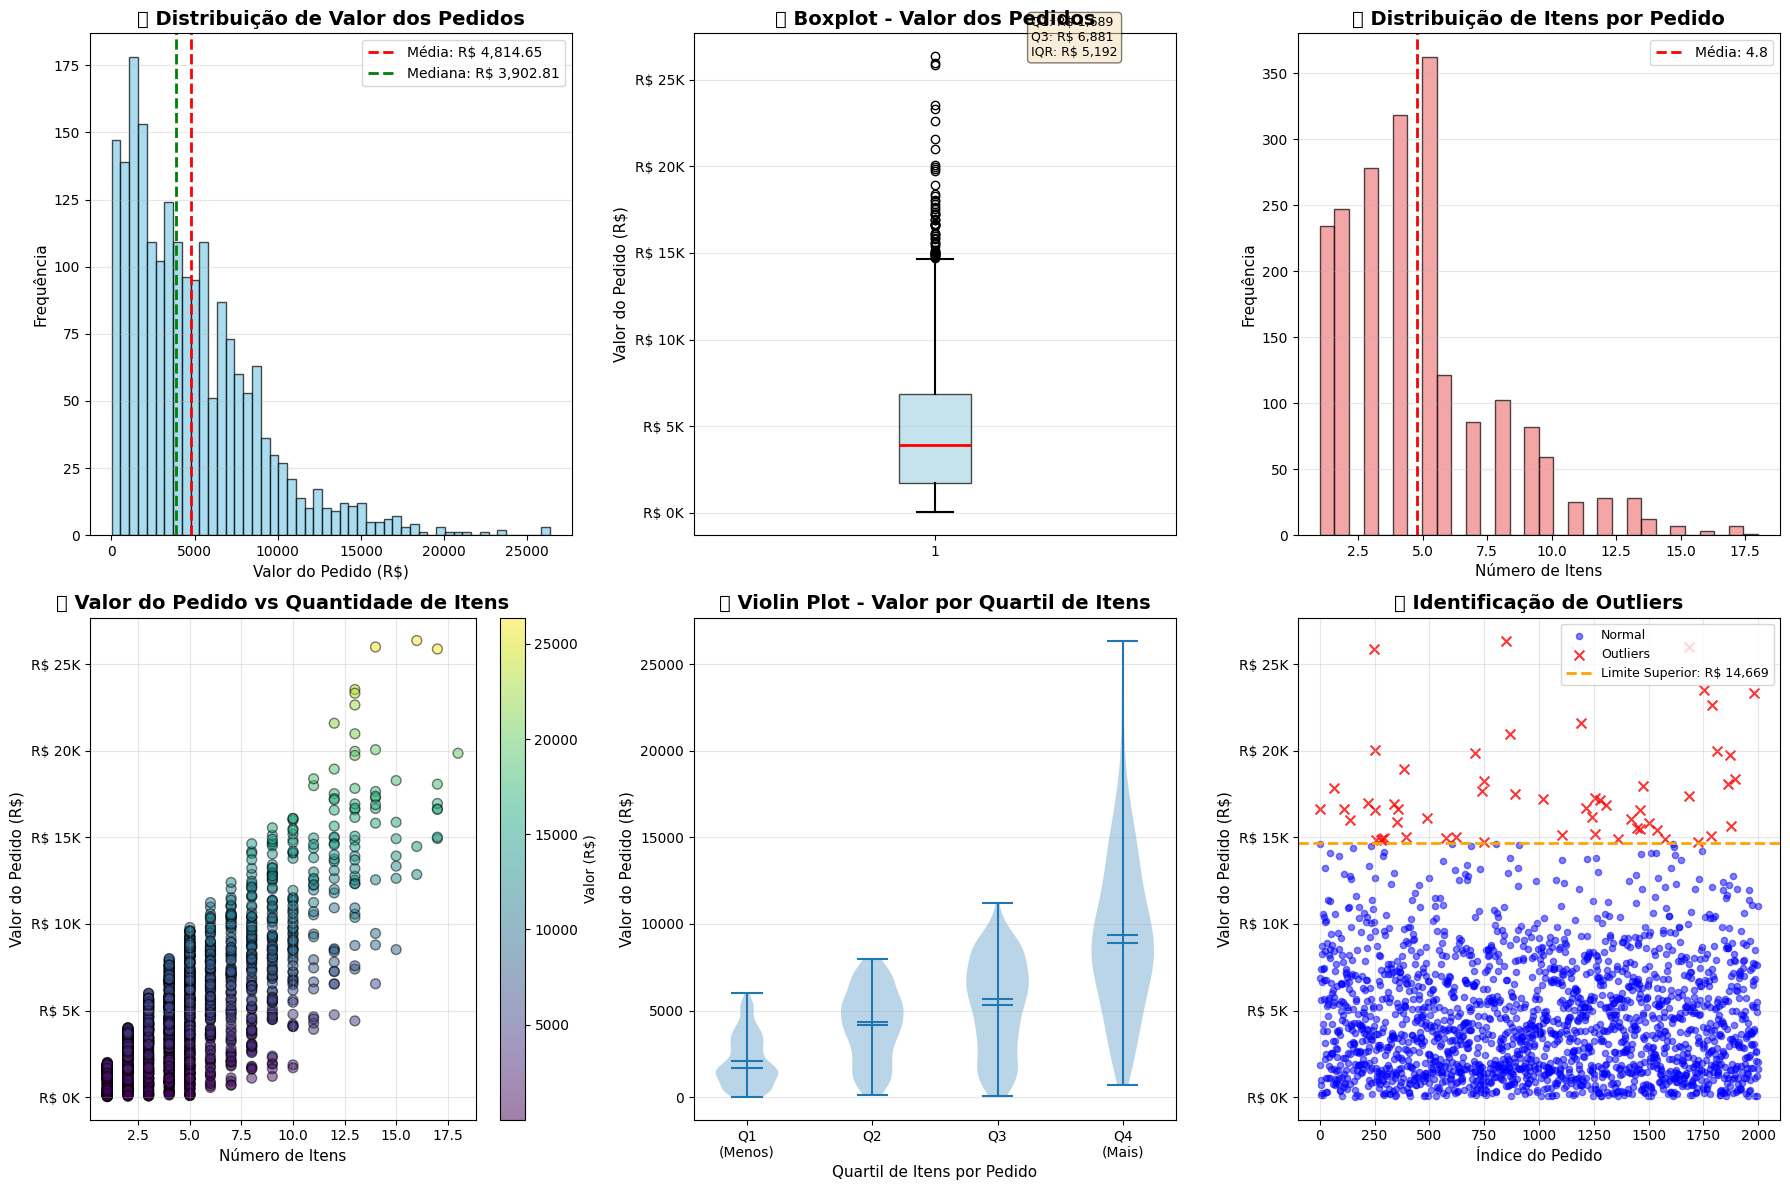


📊 ESTATÍSTICAS DESCRITIVAS:

💰 Valor dos Pedidos:
count     R$ 2,000.00
mean      R$ 4,814.65
std       R$ 3,941.46
min          R$ 21.34
25%       R$ 1,689.20
50%       R$ 3,902.81
75%       R$ 6,881.15
max      R$ 26,370.15
Name: valor_pedido, dtype: object

Desvio Padrão: R$ 3,941.46
Coeficiente de Variação: 81.86%


📦 Quantidade de Itens por Pedido:
count    2000.000000
mean        4.774500
std         3.061917
min         1.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        18.000000
Name: itens_pedido, dtype: float64


🎯 Análise de Outliers:
Total de pedidos: 2000
Outliers identificados: 57 (2.85%)
Limite inferior: R$ -6,098.74
Limite superior: R$ 14,669.09

Top 5 maiores outliers:
  Pedido 850: R$ 26,370.15
  Pedido 1683: R$ 25,997.89
  Pedido 248: R$ 25,881.61
  Pedido 1755: R$ 23,541.89
  Pedido 1981: R$ 23,326.44


In [87]:
# Query: Dados para análise de distribuição
query_dist = """
SELECT 
    f.pedido_id,
    SUM(f.valor_total) AS valor_pedido,
    SUM(f.quantidade) AS itens_pedido,
    COUNT(DISTINCT f.produto_id) AS produtos_diferentes
FROM fato_vendas f
GROUP BY f.pedido_id
"""

df_dist = pd.read_sql(query_dist, conn)

# Criar visualizações de distribuição
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Gráfico 1: Histograma de Valor dos Pedidos
ax1 = axes[0, 0]
ax1.hist(df_dist['valor_pedido'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax1.axvline(df_dist['valor_pedido'].mean(), color='red', linestyle='--', 
           linewidth=2, label=f'Média: R$ {df_dist["valor_pedido"].mean():,.2f}')
ax1.axvline(df_dist['valor_pedido'].median(), color='green', linestyle='--', 
           linewidth=2, label=f'Mediana: R$ {df_dist["valor_pedido"].median():,.2f}')
ax1.set_title('📊 Distribuição de Valor dos Pedidos', fontsize=14, fontweight='bold')
ax1.set_xlabel('Valor do Pedido (R$)', fontsize=11)
ax1.set_ylabel('Frequência', fontsize=11)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Gráfico 2: Boxplot de Valor dos Pedidos
ax2 = axes[0, 1]
box = ax2.boxplot(df_dist['valor_pedido'], vert=True, patch_artist=True,
                  boxprops=dict(facecolor='lightblue', alpha=0.7),
                  medianprops=dict(color='red', linewidth=2),
                  whiskerprops=dict(linewidth=1.5),
                  capprops=dict(linewidth=1.5))
ax2.set_title('📦 Boxplot - Valor dos Pedidos', fontsize=14, fontweight='bold')
ax2.set_ylabel('Valor do Pedido (R$)', fontsize=11)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}K'))
ax2.grid(True, alpha=0.3, axis='y')

# Adicionar estatísticas
q1 = df_dist['valor_pedido'].quantile(0.25)
q3 = df_dist['valor_pedido'].quantile(0.75)
iqr = q3 - q1
ax2.text(1.2, df_dist['valor_pedido'].max(), 
        f'Q1: R$ {q1:,.0f}\nQ3: R$ {q3:,.0f}\nIQR: R$ {iqr:,.0f}',
        fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Gráfico 3: Distribuição de Itens por Pedido
ax3 = axes[0, 2]
ax3.hist(df_dist['itens_pedido'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
ax3.axvline(df_dist['itens_pedido'].mean(), color='red', linestyle='--', 
           linewidth=2, label=f'Média: {df_dist["itens_pedido"].mean():.1f}')
ax3.set_title('📦 Distribuição de Itens por Pedido', fontsize=14, fontweight='bold')
ax3.set_xlabel('Número de Itens', fontsize=11)
ax3.set_ylabel('Frequência', fontsize=11)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Gráfico 4: Scatter - Valor vs Quantidade
ax4 = axes[1, 0]
scatter = ax4.scatter(df_dist['itens_pedido'], df_dist['valor_pedido'],
                     alpha=0.5, c=df_dist['valor_pedido'], 
                     cmap='viridis', edgecolors='black', s=50)
ax4.set_title('💰 Valor do Pedido vs Quantidade de Itens', fontsize=14, fontweight='bold')
ax4.set_xlabel('Número de Itens', fontsize=11)
ax4.set_ylabel('Valor do Pedido (R$)', fontsize=11)
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}K'))
ax4.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='Valor (R$)')

# Gráfico 5: Violin Plot - Valor por Quartil de Itens
ax5 = axes[1, 1]
df_dist['quartil_itens'] = pd.qcut(df_dist['itens_pedido'], q=4, 
                                    labels=['Q1', 'Q2', 'Q3', 'Q4'])
parts = ax5.violinplot([df_dist[df_dist['quartil_itens'] == q]['valor_pedido'].values 
                        for q in ['Q1', 'Q2', 'Q3', 'Q4']],
                       positions=[1, 2, 3, 4],
                       showmeans=True, showmedians=True)
ax5.set_title('🎻 Violin Plot - Valor por Quartil de Itens', fontsize=14, fontweight='bold')
ax5.set_xlabel('Quartil de Itens por Pedido', fontsize=11)
ax5.set_ylabel('Valor do Pedido (R$)', fontsize=11)
ax5.set_xticks([1, 2, 3, 4])
ax5.set_xticklabels(['Q1\n(Menos)', 'Q2', 'Q3', 'Q4\n(Mais)'])
ax5.grid(True, alpha=0.3, axis='y')

# Gráfico 6: Análise de Outliers
ax6 = axes[1, 2]
# Identificar outliers (valores além de 1.5 * IQR)
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = df_dist[(df_dist['valor_pedido'] < lower_bound) | 
                   (df_dist['valor_pedido'] > upper_bound)]

normal = df_dist[(df_dist['valor_pedido'] >= lower_bound) & 
                 (df_dist['valor_pedido'] <= upper_bound)]

ax6.scatter(normal.index, normal['valor_pedido'], 
           alpha=0.5, s=20, color='blue', label='Normal')
ax6.scatter(outliers.index, outliers['valor_pedido'], 
           alpha=0.8, s=50, color='red', marker='x', label='Outliers')
ax6.axhline(upper_bound, color='orange', linestyle='--', linewidth=2, 
           label=f'Limite Superior: R$ {upper_bound:,.0f}')
ax6.set_title('🎯 Identificação de Outliers', fontsize=14, fontweight='bold')
ax6.set_xlabel('Índice do Pedido', fontsize=11)
ax6.set_ylabel('Valor do Pedido (R$)', fontsize=11)
ax6.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}K'))
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas descritivas
print("\n📊 ESTATÍSTICAS DESCRITIVAS:")
print("="*70)
print("\n💰 Valor dos Pedidos:")
print(df_dist['valor_pedido'].describe().apply(lambda x: f'R$ {x:,.2f}'))
print(f"\nDesvio Padrão: R$ {df_dist['valor_pedido'].std():,.2f}")
print(f"Coeficiente de Variação: {(df_dist['valor_pedido'].std() / df_dist['valor_pedido'].mean() * 100):.2f}%")

print("\n\n📦 Quantidade de Itens por Pedido:")
print(df_dist['itens_pedido'].describe())

print("\n\n🎯 Análise de Outliers:")
print(f"Total de pedidos: {len(df_dist)}")
print(f"Outliers identificados: {len(outliers)} ({len(outliers)/len(df_dist)*100:.2f}%)")
print(f"Limite inferior: R$ {lower_bound:,.2f}")
print(f"Limite superior: R$ {upper_bound:,.2f}")
if len(outliers) > 0:
    print(f"\nTop 5 maiores outliers:")
    for idx, row in outliers.nlargest(5, 'valor_pedido').iterrows():
        print(f"  Pedido {row['pedido_id']}: R$ {row['valor_pedido']:,.2f}")
print("="*70)

### 🎯 6. Dashboard de KPIs - Resumo Executivo

C:\Users\eu\AppData\Local\Temp\ipykernel_8796\3563495570.py:218: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\eu\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eu\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eu\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\eu\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from

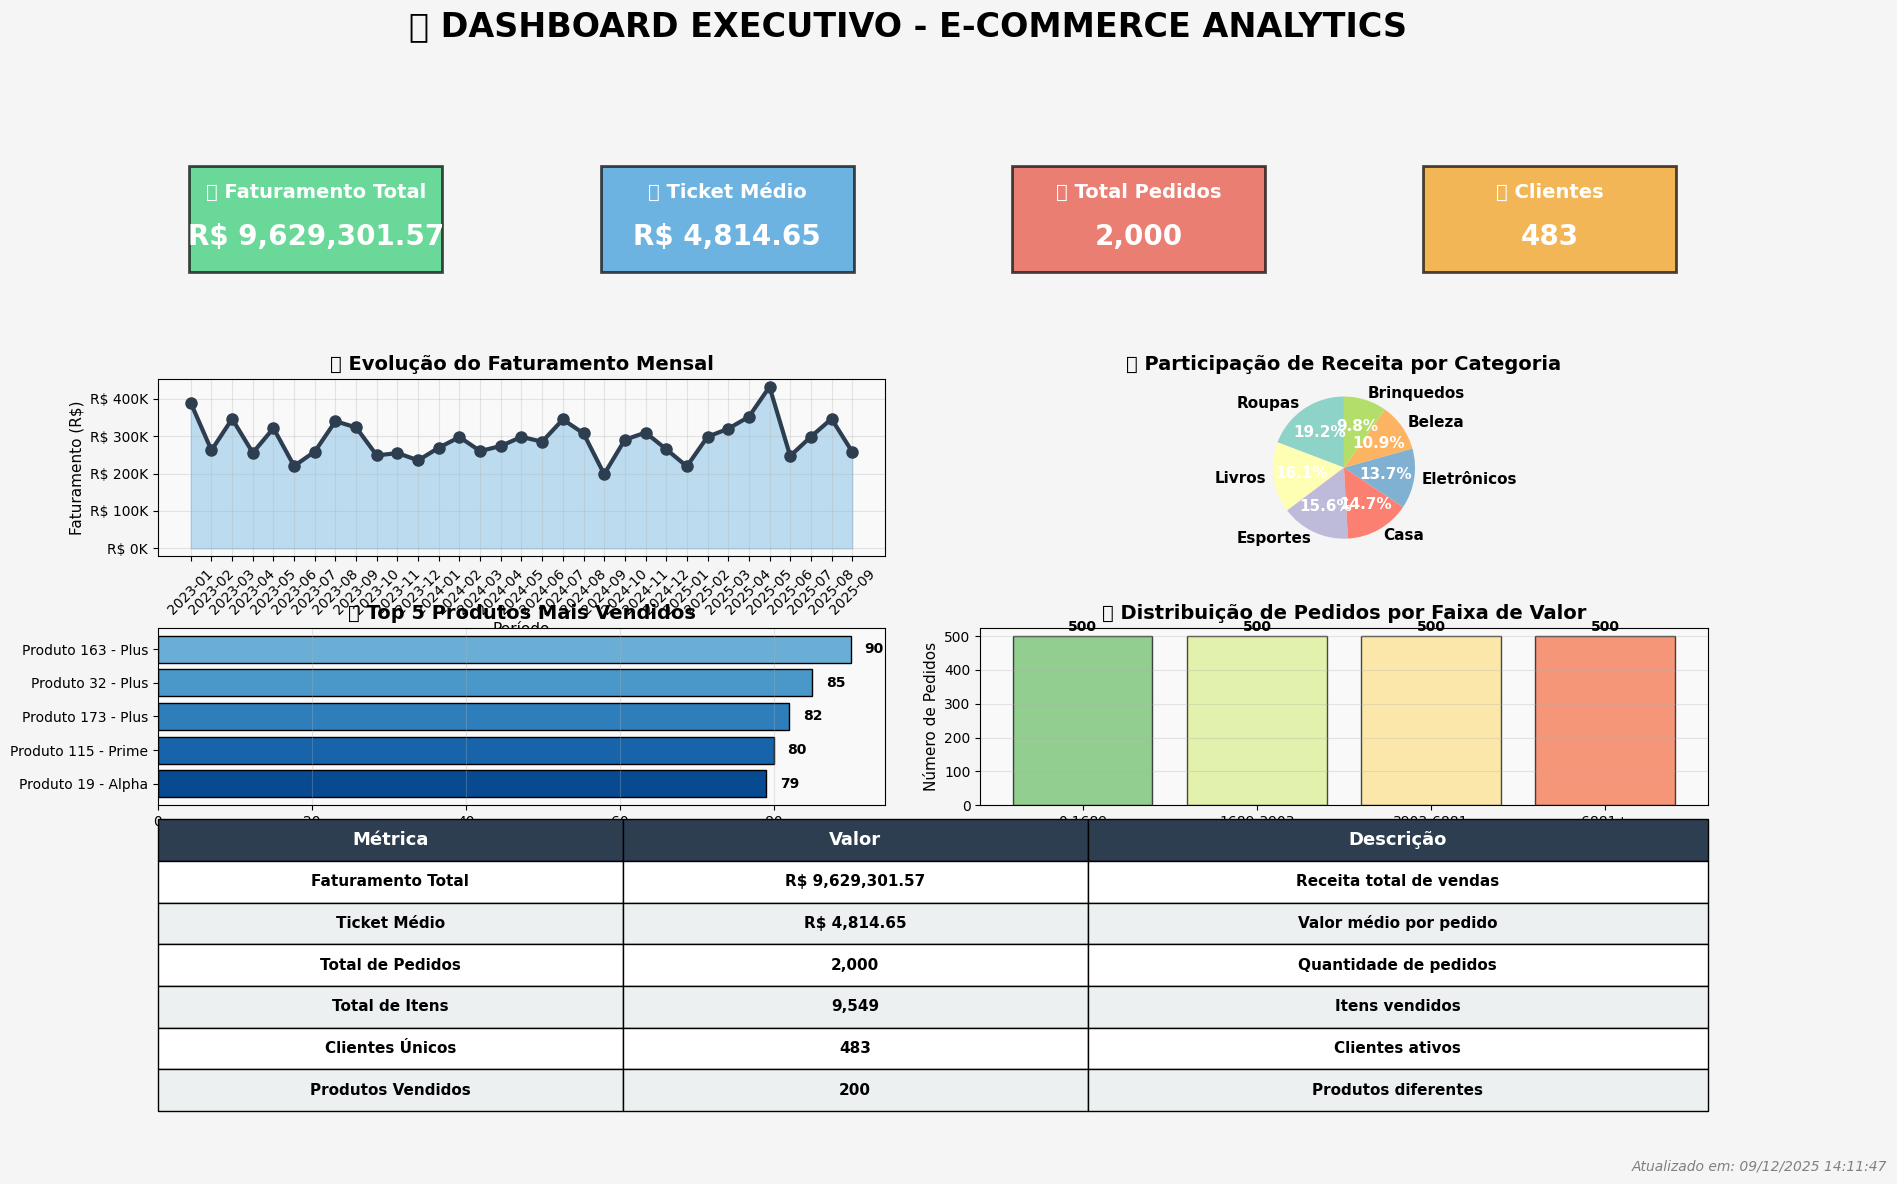


✅ DASHBOARD EXECUTIVO GERADO COM SUCESSO!

📊 Resumo dos KPIs:
  💰 Faturamento Total: R$ 9,629,301.57
  📈 Ticket Médio: R$ 4,814.65
  🛍️ Total de Pedidos: 2,000
  👥 Clientes Únicos: 483


In [88]:
# Criar um dashboard visual com os principais KPIs
from datetime import datetime
from matplotlib.patches import Rectangle

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(4, 4, hspace=0.4, wspace=0.3)

# Cor de fundo
fig.patch.set_facecolor('#f5f5f5')

# Título principal
fig.suptitle('🎯 DASHBOARD EXECUTIVO - E-COMMERCE ANALYTICS', 
             fontsize=24, fontweight='bold', y=0.98)

# Calcular KPIs
kpis = {
    'faturamento_total': df_dist['valor_pedido'].sum(),
    'ticket_medio': df_dist['valor_pedido'].mean(),
    'total_pedidos': len(df_dist),
    'itens_totais': df_dist['itens_pedido'].sum(),
}

# Buscar dados adicionais
query_kpis = """
SELECT 
    COUNT(DISTINCT f.cliente_id) as clientes,
    COUNT(DISTINCT f.produto_id) as produtos
FROM fato_vendas f
"""
df_kpis_extra = pd.read_sql(query_kpis, conn)
kpis['clientes'] = df_kpis_extra['clientes'][0]
kpis['produtos'] = df_kpis_extra['produtos'][0]

# KPI Cards (primeira linha)
kpi_data = [
    ('💰 Faturamento Total', f"R$ {kpis['faturamento_total']:,.2f}", '#2ecc71'),
    ('📈 Ticket Médio', f"R$ {kpis['ticket_medio']:,.2f}", '#3498db'),
    ('🛍️ Total Pedidos', f"{kpis['total_pedidos']:,}", '#e74c3c'),
    ('👥 Clientes', f"{kpis['clientes']:,}", '#f39c12')
]

for i, (label, value, color) in enumerate(kpi_data):
    ax = fig.add_subplot(gs[0, i])
    ax.axis('off')
    
    # Criar retângulo colorido
    rect = Rectangle((0.1, 0.2), 0.8, 0.6, 
                     facecolor=color, edgecolor='black', linewidth=2, alpha=0.7)
    ax.add_patch(rect)
    
    # Adicionar texto
    ax.text(0.5, 0.7, label, ha='center', va='top', 
           fontsize=14, fontweight='bold', color='white',
           transform=ax.transAxes)
    ax.text(0.5, 0.4, value, ha='center', va='center',
           fontsize=20, fontweight='bold', color='white',
           transform=ax.transAxes)

# Gráfico 1: Evolução mensal (linha 2, colunas 0-1)
ax1 = fig.add_subplot(gs[1, :2])
if 'df_fat' in locals() and len(df_fat) > 0:
    ax1.fill_between(range(len(df_fat)), df_fat['faturamento'], alpha=0.3, color='#3498db')
    ax1.plot(range(len(df_fat)), df_fat['faturamento'], 
            marker='o', linewidth=3, markersize=8, color='#2c3e50')
    ax1.set_title('📈 Evolução do Faturamento Mensal', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Período', fontsize=11)
    ax1.set_ylabel('Faturamento (R$)', fontsize=11)
    ax1.set_xticks(range(len(df_fat)))
    ax1.set_xticklabels(df_fat['ano_mes'], rotation=45)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1000:.0f}K'))
    ax1.grid(True, alpha=0.3)
    ax1.set_facecolor('#f9f9f9')
else:
    ax1.text(0.5, 0.5, 'Dados de faturamento mensal não disponíveis', 
            ha='center', va='center', transform=ax1.transAxes)
    ax1.set_facecolor('#f9f9f9')

# Gráfico 2: Top Categorias (linha 2, colunas 2-3)
ax2 = fig.add_subplot(gs[1, 2:])
if 'df_cat' in locals() and len(df_cat) > 0:
    colors_pie = plt.cm.Set3(range(len(df_cat)))
    wedges, texts, autotexts = ax2.pie(df_cat['receita'], 
                                        labels=df_cat['categoria'],
                                        autopct='%1.1f%%',
                                        startangle=90,
                                        colors=colors_pie,
                                        textprops={'fontsize': 11, 'fontweight': 'bold'})
    for autotext in autotexts:
        autotext.set_color('white')
    ax2.set_title('📊 Participação de Receita por Categoria', fontsize=14, fontweight='bold')
else:
    ax2.text(0.5, 0.5, 'Dados de categorias não disponíveis', 
            ha='center', va='center', transform=ax2.transAxes)

# Gráfico 3: Top 5 Produtos (linha 3, colunas 0-1)
ax3 = fig.add_subplot(gs[2, :2])
if 'df_top10' in locals() and len(df_top10) > 0:
    top5_produtos = df_top10.head(5)
    colors_bars = plt.cm.Blues(np.linspace(0.5, 0.9, len(top5_produtos)))
    bars = ax3.barh(top5_produtos['nome'], top5_produtos['total_vendido'], 
                   color=colors_bars, edgecolor='black')
    ax3.set_title('🏆 Top 5 Produtos Mais Vendidos', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Quantidade Vendida', fontsize=11)
    ax3.invert_yaxis()
    ax3.set_facecolor('#f9f9f9')
    ax3.grid(True, alpha=0.3, axis='x')
    
    # Adicionar valores
    for bar, val in zip(bars, top5_produtos['total_vendido']):
        ax3.text(bar.get_width() + max(top5_produtos['total_vendido'])*0.02,
                bar.get_y() + bar.get_height()/2,
                f'{val}', ha='left', va='center', fontweight='bold')
else:
    ax3.text(0.5, 0.5, 'Dados de produtos não disponíveis', 
            ha='center', va='center', transform=ax3.transAxes)
    ax3.set_facecolor('#f9f9f9')

# Gráfico 4: Distribuição de Pedidos (linha 3, colunas 2-3)
ax4 = fig.add_subplot(gs[2, 2:])
# Criar bins dinâmicos e robustos
max_valor = df_dist['valor_pedido'].max()
min_valor = df_dist['valor_pedido'].min()

# Definir bins de forma mais inteligente
if max_valor <= 1000:
    bins = [0, 200, 400, 600, 800, 1000]
    labels = ['0-200', '200-400', '400-600', '600-800', '800-1K']
elif max_valor <= 5000:
    bins = [0, 1000, 2000, 3000, 4000, 5000]
    labels = ['0-1K', '1K-2K', '2K-3K', '3K-4K', '4K-5K']
elif max_valor <= 10000:
    bins = [0, 2000, 4000, 6000, 8000, 10000]
    labels = ['0-2K', '2K-4K', '4K-6K', '6K-8K', '8K-10K']
else:
    # Para valores muito altos, usar percentis
    q1 = df_dist['valor_pedido'].quantile(0.25)
    q2 = df_dist['valor_pedido'].quantile(0.50)
    q3 = df_dist['valor_pedido'].quantile(0.75)
    bins = [0, q1, q2, q3, max_valor]
    labels = [f'0-{q1:.0f}', f'{q1:.0f}-{q2:.0f}', f'{q2:.0f}-{q3:.0f}', f'{q3:.0f}+']

# Adicionar infinito ao último bin para garantir inclusão de todos valores
bins[-1] = np.inf

try:
    df_dist['faixa'] = pd.cut(df_dist['valor_pedido'], bins=bins, labels=labels, include_lowest=True)
    faixa_counts = df_dist['faixa'].value_counts().sort_index()
    
    # Filtrar apenas faixas com dados
    faixa_counts = faixa_counts[faixa_counts > 0]
    
    if len(faixa_counts) > 0:
        colors_faixa = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(faixa_counts)))
        bars4 = ax4.bar(range(len(faixa_counts)), faixa_counts.values, 
                       color=colors_faixa, edgecolor='black', alpha=0.7)
        ax4.set_title('💵 Distribuição de Pedidos por Faixa de Valor', fontsize=14, fontweight='bold')
        ax4.set_ylabel('Número de Pedidos', fontsize=11)
        ax4.set_xticks(range(len(faixa_counts)))
        ax4.set_xticklabels(faixa_counts.index, rotation=0)
        ax4.set_facecolor('#f9f9f9')
        ax4.grid(True, alpha=0.3, axis='y')
        
        # Adicionar valores nas barras
        for bar, val in zip(bars4, faixa_counts.values):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(faixa_counts)*0.01,
                    f'{val}', ha='center', va='bottom', fontweight='bold')
    else:
        ax4.text(0.5, 0.5, 'Dados insuficientes para distribuição', 
                ha='center', va='center', transform=ax4.transAxes)
except Exception as e:
    ax4.text(0.5, 0.5, f'Erro ao criar distribuição:\n{str(e)[:50]}', 
            ha='center', va='center', transform=ax4.transAxes)
    print(f"⚠️ Erro na distribuição de pedidos: {e}")

ax4.set_facecolor('#f9f9f9')

# Tabela de métricas (linha 4)
ax5 = fig.add_subplot(gs[3, :])
ax5.axis('tight')
ax5.axis('off')

# Preparar dados da tabela
metricas_tabela = [
    ['Métrica', 'Valor', 'Descrição'],
    ['Faturamento Total', f"R$ {kpis['faturamento_total']:,.2f}", 'Receita total de vendas'],
    ['Ticket Médio', f"R$ {kpis['ticket_medio']:,.2f}", 'Valor médio por pedido'],
    ['Total de Pedidos', f"{kpis['total_pedidos']:,}", 'Quantidade de pedidos'],
    ['Total de Itens', f"{kpis['itens_totais']:,}", 'Itens vendidos'],
    ['Clientes Únicos', f"{kpis['clientes']:,}", 'Clientes ativos'],
    ['Produtos Vendidos', f"{kpis['produtos']:,}", 'Produtos diferentes'],
]

# Criar tabela
table = ax5.table(cellText=metricas_tabela, cellLoc='center', loc='center',
                 colWidths=[0.3, 0.3, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Estilizar cabeçalho
for i in range(3):
    table[(0, i)].set_facecolor('#2c3e50')
    table[(0, i)].set_text_props(weight='bold', color='white', fontsize=13)

# Estilizar células
for i in range(1, len(metricas_tabela)):
    for j in range(3):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#ecf0f1')
        else:
            table[(i, j)].set_facecolor('#ffffff')
        table[(i, j)].set_text_props(fontweight='bold')

# Adicionar timestamp
fig.text(0.99, 0.01, f'Atualizado em: {datetime.now().strftime("%d/%m/%Y %H:%M:%S")}',
        ha='right', va='bottom', fontsize=10, style='italic', color='gray')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✅ DASHBOARD EXECUTIVO GERADO COM SUCESSO!")
print("="*80)
print(f"\n📊 Resumo dos KPIs:")
print(f"  💰 Faturamento Total: R$ {kpis['faturamento_total']:,.2f}")
print(f"  📈 Ticket Médio: R$ {kpis['ticket_medio']:,.2f}")
print(f"  🛍️ Total de Pedidos: {kpis['total_pedidos']:,}")
print(f"  👥 Clientes Únicos: {kpis['clientes']:,}")
print("="*80)

## 🔚 Finalização

In [89]:
# Fechar conexão com o banco de dados
try:
    if 'conn' in locals() and conn:
        conn.close()
        print("✅ Conexão com o banco de dados fechada com sucesso.")
    else:
        print("ℹ️ Nenhuma conexão ativa encontrada.")
except Exception as e:
    print(f"❌ Erro ao fechar conexão: {e}")

✅ Conexão com o banco de dados fechada com sucesso.
